# Import, chargement et rapide exploration du DF

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import chi2_contingency

In [4]:
path_data = os.path.join("..", "Data", "daily_all.csv")
df = pd.read_csv(path_data, index_col=0)

In [5]:
df = df.drop(columns=["date", "week_start"])

In [6]:
df.head()

,workday,profession,work_mode,chronotype,age,sex,height_cm,mental_health_history,exercise_habit,caffeine_sensitivity,...,workouts_count,cheat_meals_count,has_intervention,intervention_diet_coaching,intervention_exercise_plan,intervention_meditation,intervention_sick_leave,intervention_therapy,intervention_vacation,intervention_workload_cap
user_id,,,,,,,,,,,,,,,,,,,,,
1,True,operations,onsite,morning,27,female,174,anxiety,medium,low,...,10,1,False,False,False,False,False,False,False,False
1,True,operations,onsite,morning,27,female,174,anxiety,medium,low,...,10,1,False,False,False,False,False,False,False,False
1,True,operations,onsite,morning,27,female,174,anxiety,medium,low,...,10,1,False,False,False,False,False,False,False,False
1,True,operations,onsite,morning,27,female,174,anxiety,medium,low,...,10,1,False,False,False,False,False,False,False,False
1,True,operations,onsite,morning,27,female,174,anxiety,medium,low,...,10,1,False,False,False,False,False,False,False,False


In [7]:
col_pred = [
    "intervention_diet_coaching",
    "intervention_exercise_plan",
    "intervention_meditation",
    "intervention_sick_leave",
    "intervention_therapy",
    "intervention_vacation",
    "intervention_workload_cap"
]

In [8]:
df.columns

Index(['workday', 'profession', 'work_mode', 'chronotype', 'age', 'sex',
       'height_cm', 'mental_health_history', 'exercise_habit',
       'caffeine_sensitivity', 'baseline_bmi', 'sleep_hours', 'sleep_quality',
       'work_hours', 'meetings_count', 'tasks_completed', 'emails_received',
       'commute_minutes', 'exercise_minutes', 'steps_count', 'caffeine_mg',
       'alcohol_units', 'screen_time_hours', 'social_interactions',
       'outdoor_time_minutes', 'diet_quality', 'calories_intake',
       'stress_level', 'mood_score', 'energy_level', 'focus_score',
       'work_pressure', 'weather_mood_impact', 'weight_kg', 'job_satisfaction',
       'perceived_stress_scale', 'anxiety_score', 'depression_score',
       'sleep_debt_hours', 'avg_weight_kg_week', 'workouts_count',
       'cheat_meals_count', 'has_intervention', 'intervention_diet_coaching',
       'intervention_exercise_plan', 'intervention_meditation',
       'intervention_sick_leave', 'intervention_therapy',
       'inter

# Biais


### Visualisation de potentiel biais

In [9]:
# --- Catégorisation de l'âge ---
bins_age = [20, 35, 50, 65]
labels_age = ['Jeune (20-35)', 'Adulte (35-50)', 'Senior (50-65)']
df['age_group'] = pd.cut(df['age'], bins=bins_age, labels=labels_age, include_lowest=True)

# --- Catégorisation de la taille ---
bins_height = [140, 160, 180, 200]
labels_height = ['Petit (140-160)', 'Moyen (160-180)', 'Grand (180-200)']
df['height_group'] = pd.cut(df['height_cm'], bins=bins_height, labels=labels_height, include_lowest=True)

# --- Catégorisation du BMI ---
bins_bmi = [18, 23, 28, 32]
labels_bmi = ['Normal (18-23)', 'Élevé (23-28)', 'Haut (28-32)']
df['bmi_group'] = pd.cut(df['baseline_bmi'], bins=bins_bmi, labels=labels_bmi, include_lowest=True)


In [10]:
cols_group = [
    "age_group",
    "height_group",
    "bmi_group",
    "sex",
    "profession",
    "work_mode",
    "chronotype",
    "mental_health_history",
    "exercise_habit",
    "caffeine_sensitivity"
]

In [11]:
df_unique_user = df.groupby("user_id").first()

df_unique_user = df_unique_user[cols_group]

In [12]:
def plot_biais(df, df_unique_user, group_col, col_pred, nb_ligne, nb_col):
    sns.set(style="whitegrid")
    # -------- Pie chart --------
    plt.figure(figsize=(15, 6))
    df_unique_user[group_col].value_counts().plot.pie(
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 8}
    )
    plt.title(f"Répartition du groupe {group_col}", fontsize=10)
    plt.ylabel('')
    plt.axis('equal')  # pour un cercle parfait
    plt.tight_layout()
    plt.show()      

    # -------- Histogrammes des interventions --------
    fig, axes = plt.subplots(nb_ligne, nb_col, figsize=(16, 8))
    axes = axes.flatten()
    
    dict_chi2 = {}
    
    for i, target in enumerate(col_pred):
        if i >= len(axes):
            break
        
        # Calcul du taux moyen d'intervention pour chaque catégorie
        tot_par_groupe = df.groupby(group_col, observed=True)[target].sum().reset_index()
        tot = df[target].sum()
        tot_par_groupe['percent'] = (tot_par_groupe[target] / tot) * 100
        
        sns.barplot(data=tot_par_groupe, x=group_col, y='percent', ax=axes[i])
        axes[i].set_title(f"{target} selon {group_col}")
        axes[i].set_ylabel("Pourcentage (%)")
        axes[i].set_xlabel("")
        axes[i].tick_params(axis='x', rotation=45)
        
            # Créer une table de contingence
        contingency_table = pd.crosstab(df[group_col], df[target])

        # Test du chi²
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        dict_chi2[target] = [chi2, p, dof, contingency_table]
    
    plt.suptitle(f"Répartition des interventions selon {group_col}", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # On utilise le test du Chi² pour vérifier si la distribution des interventions
    # dépend des groupes (âge, sexe, etc.). Avec un grand dataset, la p-value seule
    # peut être trompeuse, donc on ajoute Cramer's V pour mesurer la force de l'association.

    results = []
    for target in col_pred:
        chi2, p, dof, contingency_table = dict_chi2[target]
        
        # Taille de l'échantillon
        n = contingency_table.sum().sum()
        # Calcul de Cramer's V
        k = min(contingency_table.shape)
        cramers_v = np.sqrt(chi2 / (n * (k - 1)))

        if p < 0.001 and cramers_v >= 0.1:
            conclusion = "Biais significatif"
        elif p < 0.001:
            conclusion = "Différence statistique mais effet faible"
        else:
            conclusion = "Pas de biais"
            
        results.append([group_col, target, chi2, p, dof, cramers_v, conclusion])

    df_results = pd.DataFrame(results, columns=["Group", "Intervention", "Chi²", "p-value", "dof", "cramer's V", "Conclusion"])
    display(df_results.style)


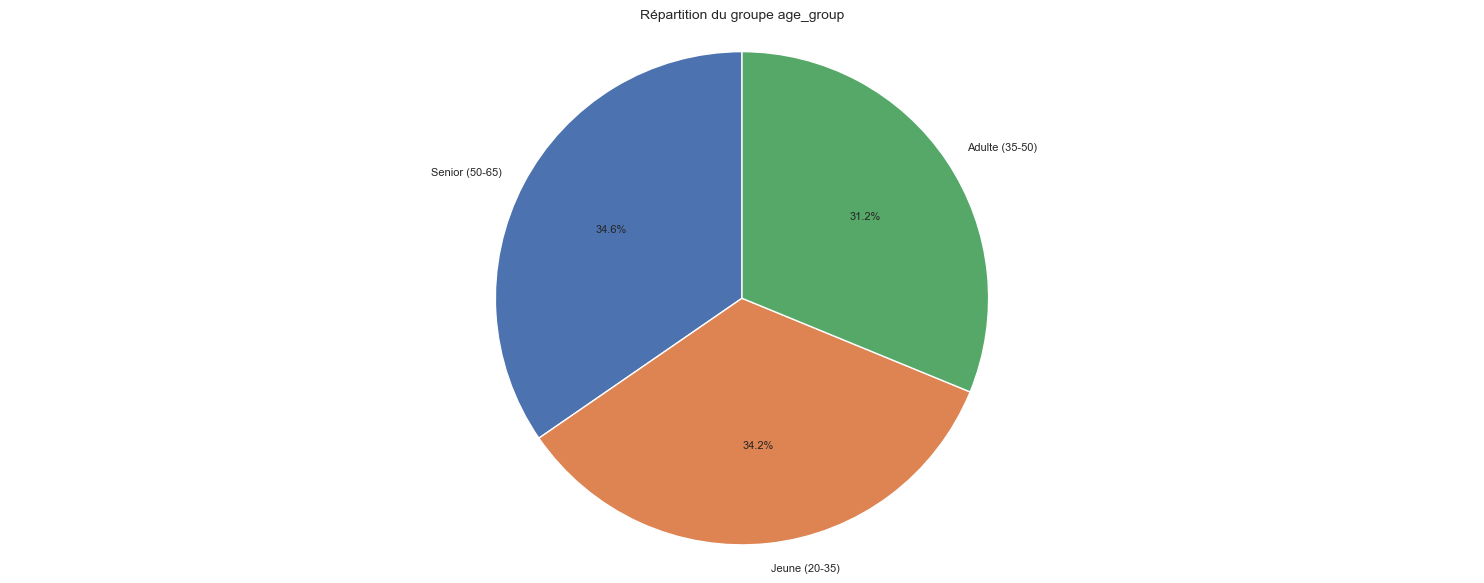

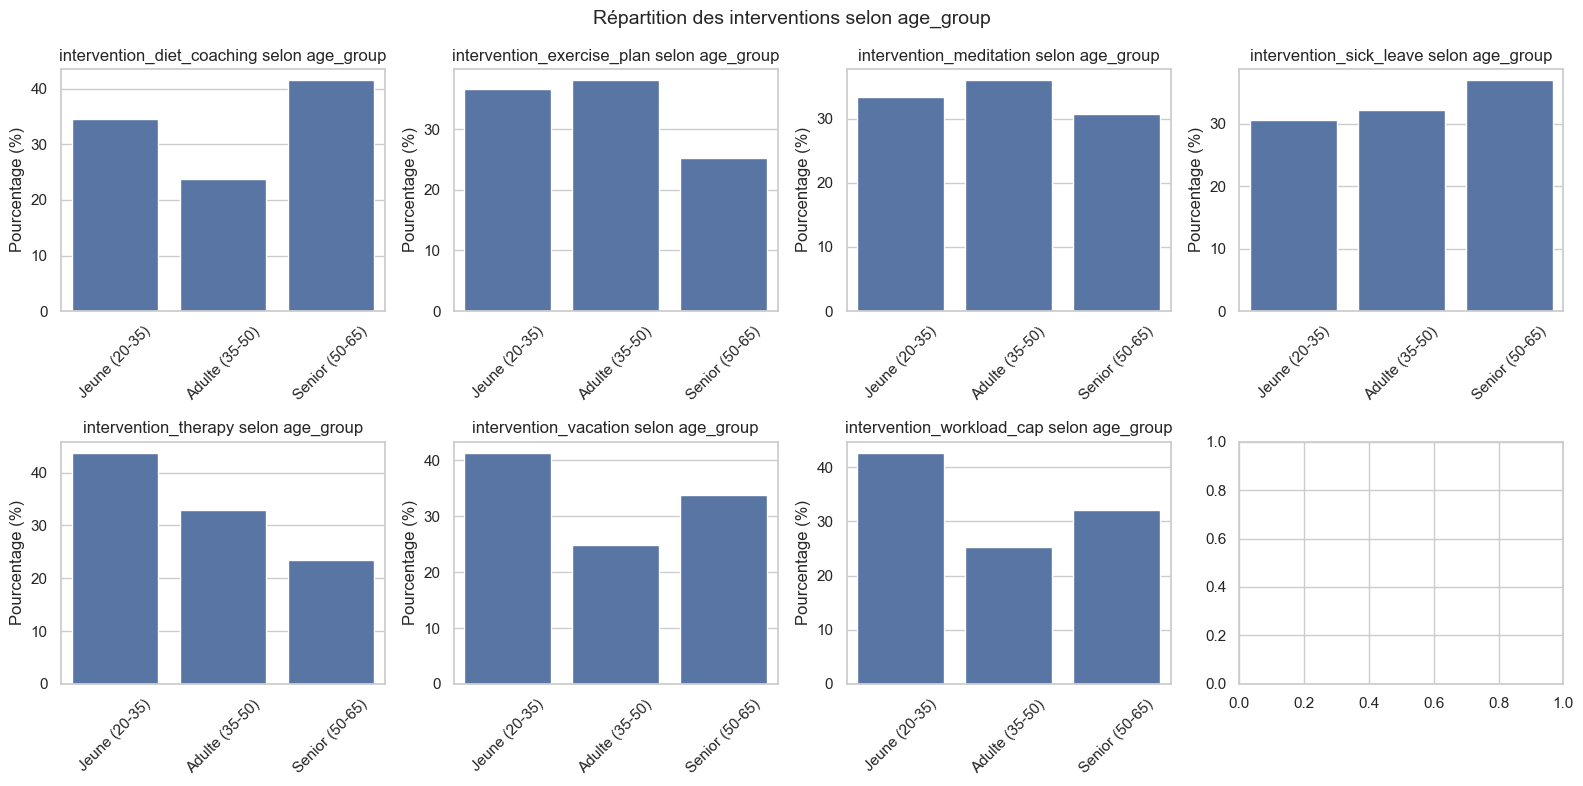

,Group,Intervention,Chi²,p-value,dof,cramer's V,Conclusion
0,age_group,intervention_diet_coaching,71.365027,0.000000,2,0.009881,Différence statistique mais effet faible
1,age_group,intervention_exercise_plan,95.614711,0.000000,2,0.011437,Différence statistique mais effet faible
2,age_group,intervention_meditation,5.430920,0.066174,2,0.002726,Pas de biais
3,age_group,intervention_sick_leave,2.081886,0.353122,2,0.001688,Pas de biais
4,age_group,intervention_therapy,14.071179,0.000880,2,0.004387,Différence statistique mais effet faible
5,age_group,intervention_vacation,15.595973,0.000411,2,0.004619,Différence statistique mais effet faible
6,age_group,intervention_workload_cap,35.658772,0.000000,2,0.006984,Différence statistique mais effet faible


In [13]:
col_idx = 0
plot_biais(df, df_unique_user, cols_group[col_idx], col_pred, 2, 4)
col_idx+=1

**Analyse du biais lié à la variable age_group**

La variable age_group présente une répartition équilibrée entre les trois catégories :

Jeune (20–35 ans) : 34,2 %
Adulte (35–50 ans) : 31,2 %
Senior (50–65 ans) : 34,6 %

Cette distribution homogène garantit une bonne représentativité des groupes d’âge dans le dataset.
Concernant les interventions, l’analyse des histogrammes montre que les taux d’attribution des différentes interventions (ex. coaching alimentaire, plan d’exercice, méditation, etc.) sont relativement similaires entre les trois groupes. Aucune catégorie ne présente une surreprésentation ou sous-représentation marquée par rapport à sa proportion dans la population.

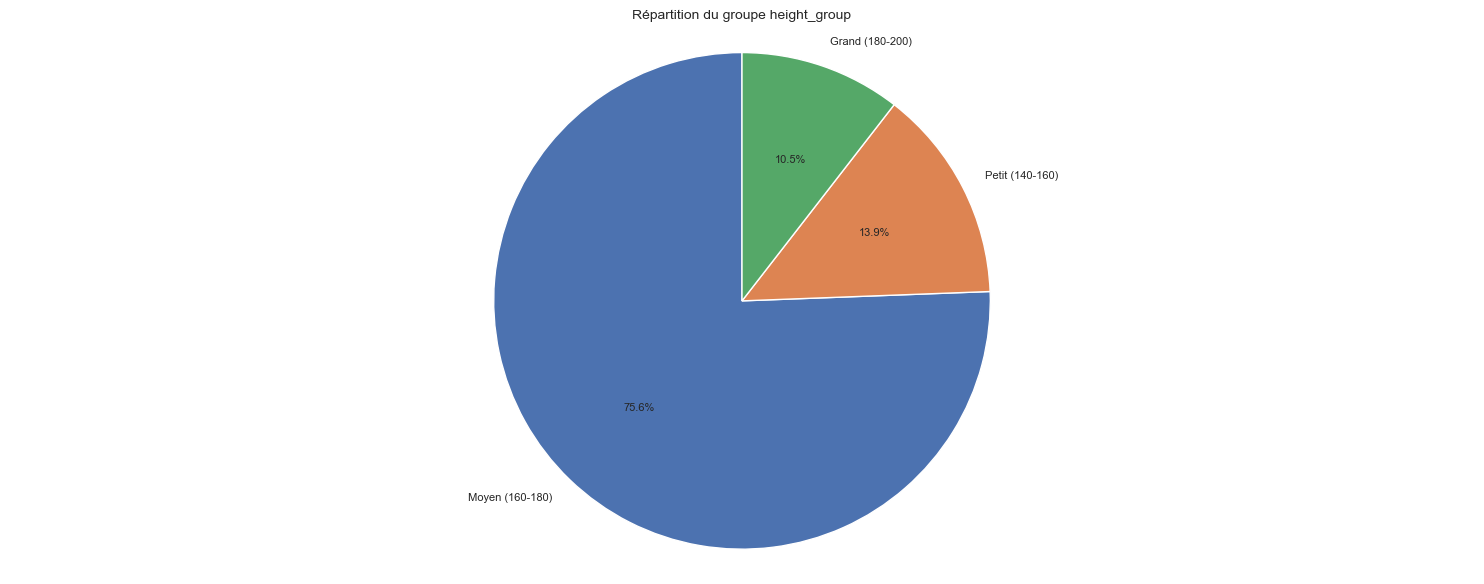

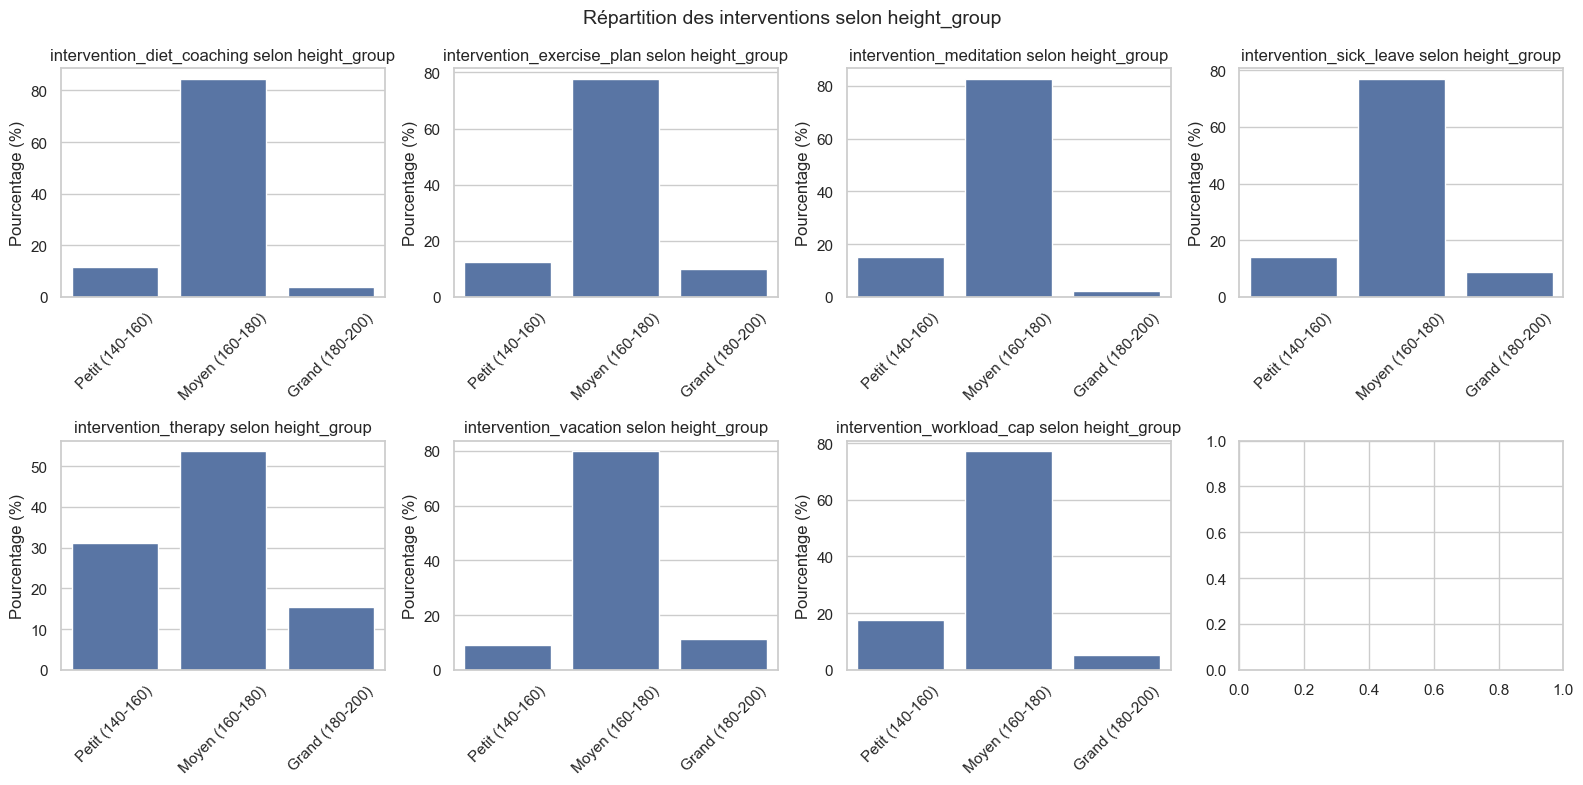

,Group,Intervention,Chi²,p-value,dof,cramer's V,Conclusion
0,height_group,intervention_diet_coaching,129.539899,0.000000,2,0.013312,Différence statistique mais effet faible
1,height_group,intervention_exercise_plan,6.465553,0.039448,2,0.002974,Pas de biais
2,height_group,intervention_meditation,33.180546,0.000000,2,0.006737,Différence statistique mais effet faible
3,height_group,intervention_sick_leave,1.063778,0.587494,2,0.001206,Pas de biais
4,height_group,intervention_therapy,66.276001,0.000000,2,0.009522,Différence statistique mais effet faible
5,height_group,intervention_vacation,10.664964,0.004832,2,0.003820,Pas de biais
6,height_group,intervention_workload_cap,39.544625,0.000000,2,0.007355,Différence statistique mais effet faible


In [14]:
plot_biais(df, df_unique_user, cols_group[col_idx], col_pred, 2, 4)
col_idx+=1

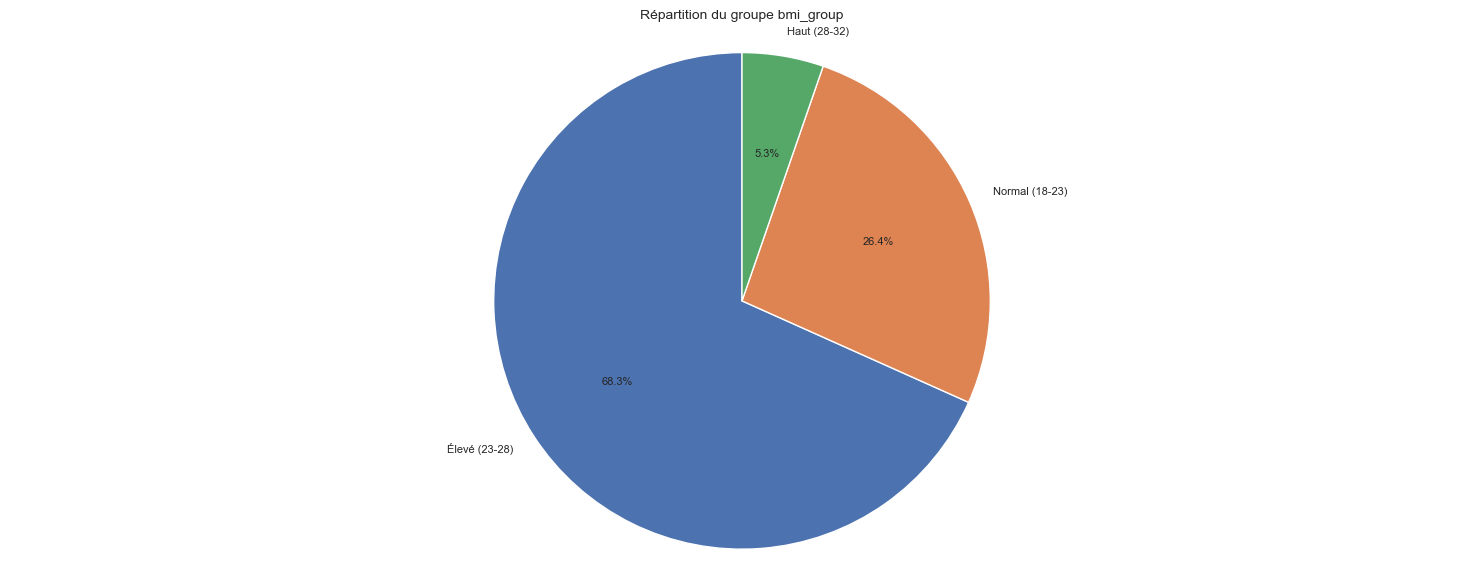

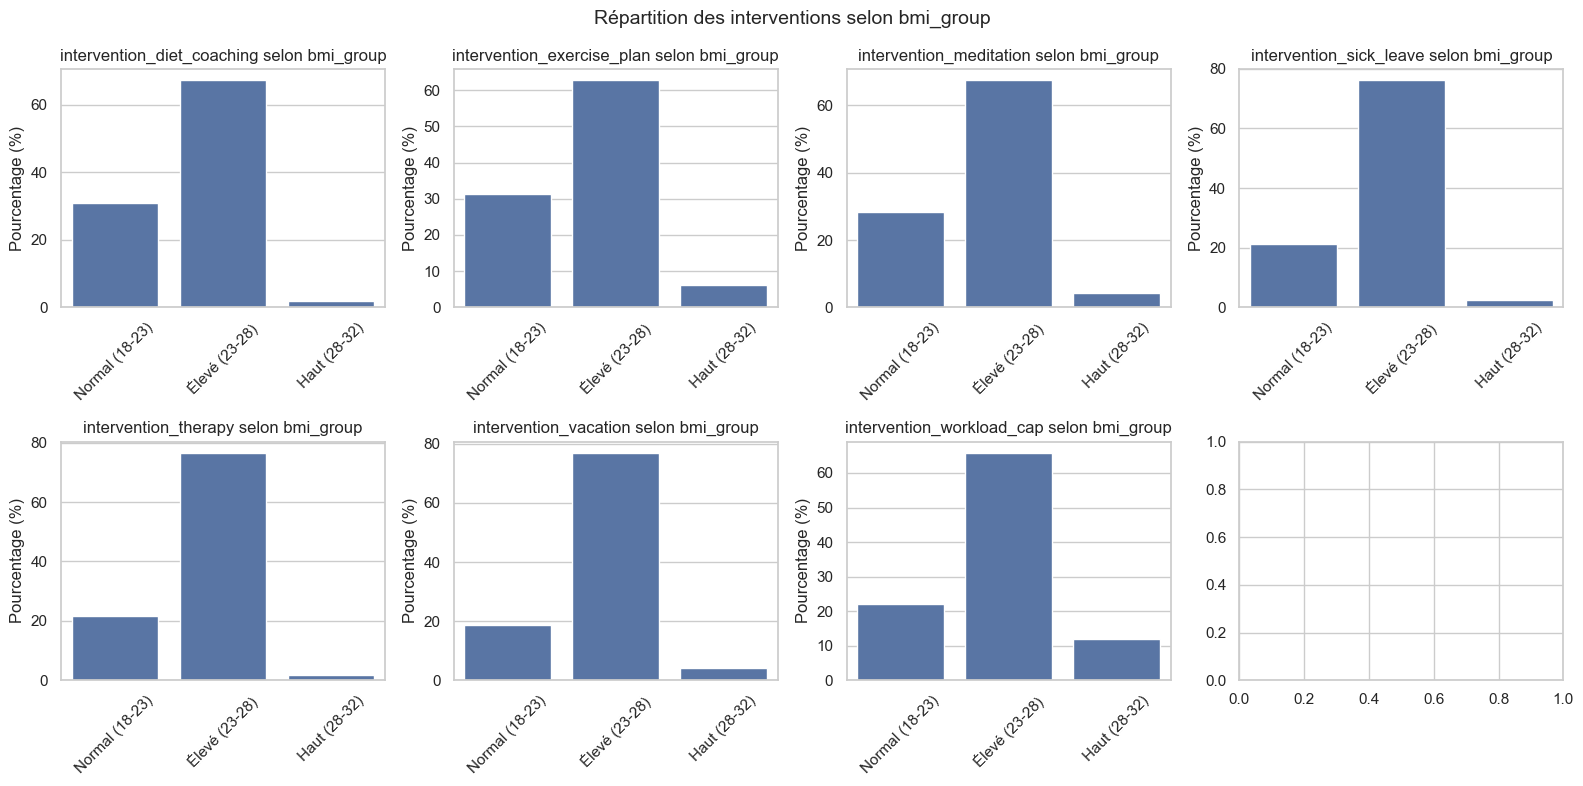

,Group,Intervention,Chi²,p-value,dof,cramer's V,Conclusion
0,bmi_group,intervention_diet_coaching,69.459848,0.000000,2,0.009748,Différence statistique mais effet faible
1,bmi_group,intervention_exercise_plan,32.290918,0.000000,2,0.006646,Différence statistique mais effet faible
2,bmi_group,intervention_meditation,1.674537,0.432891,2,0.001514,Pas de biais
3,bmi_group,intervention_sick_leave,12.365554,0.002065,2,0.004113,Pas de biais
4,bmi_group,intervention_therapy,9.275263,0.009681,2,0.003562,Pas de biais
5,bmi_group,intervention_vacation,19.452642,0.000060,2,0.005159,Différence statistique mais effet faible
6,bmi_group,intervention_workload_cap,98.442096,0.000000,2,0.011605,Différence statistique mais effet faible


In [15]:
plot_biais(df, df_unique_user, cols_group[col_idx], col_pred, 2, 4)
col_idx+=1

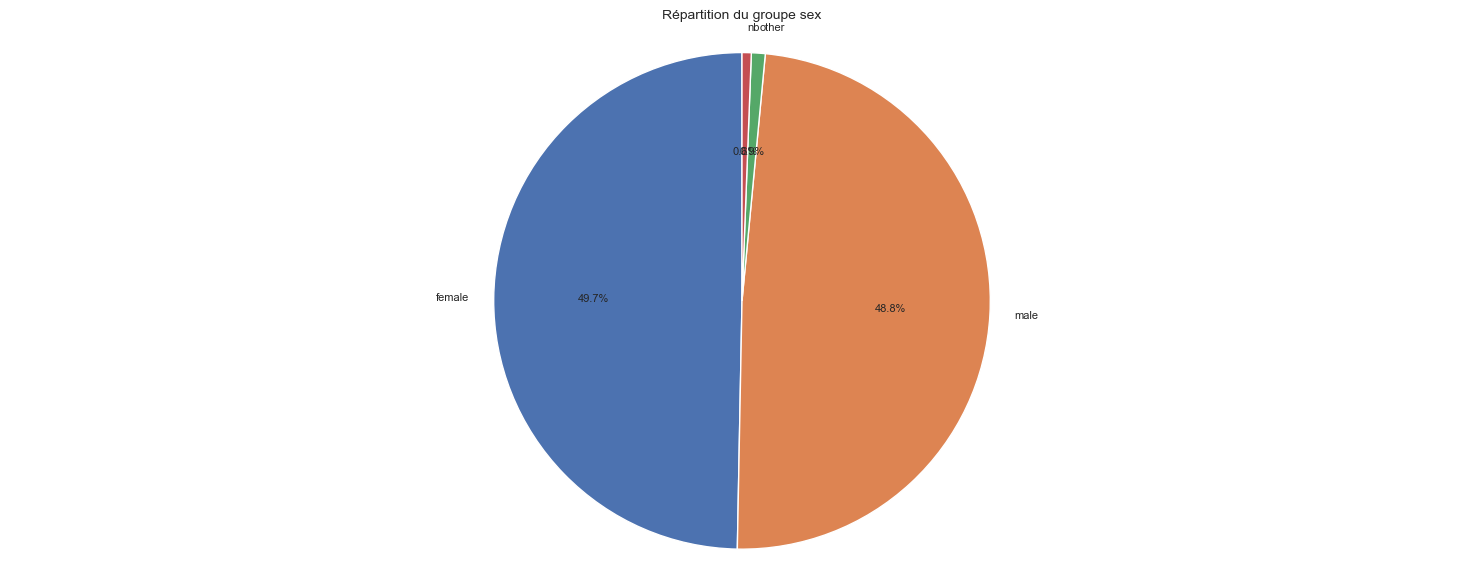

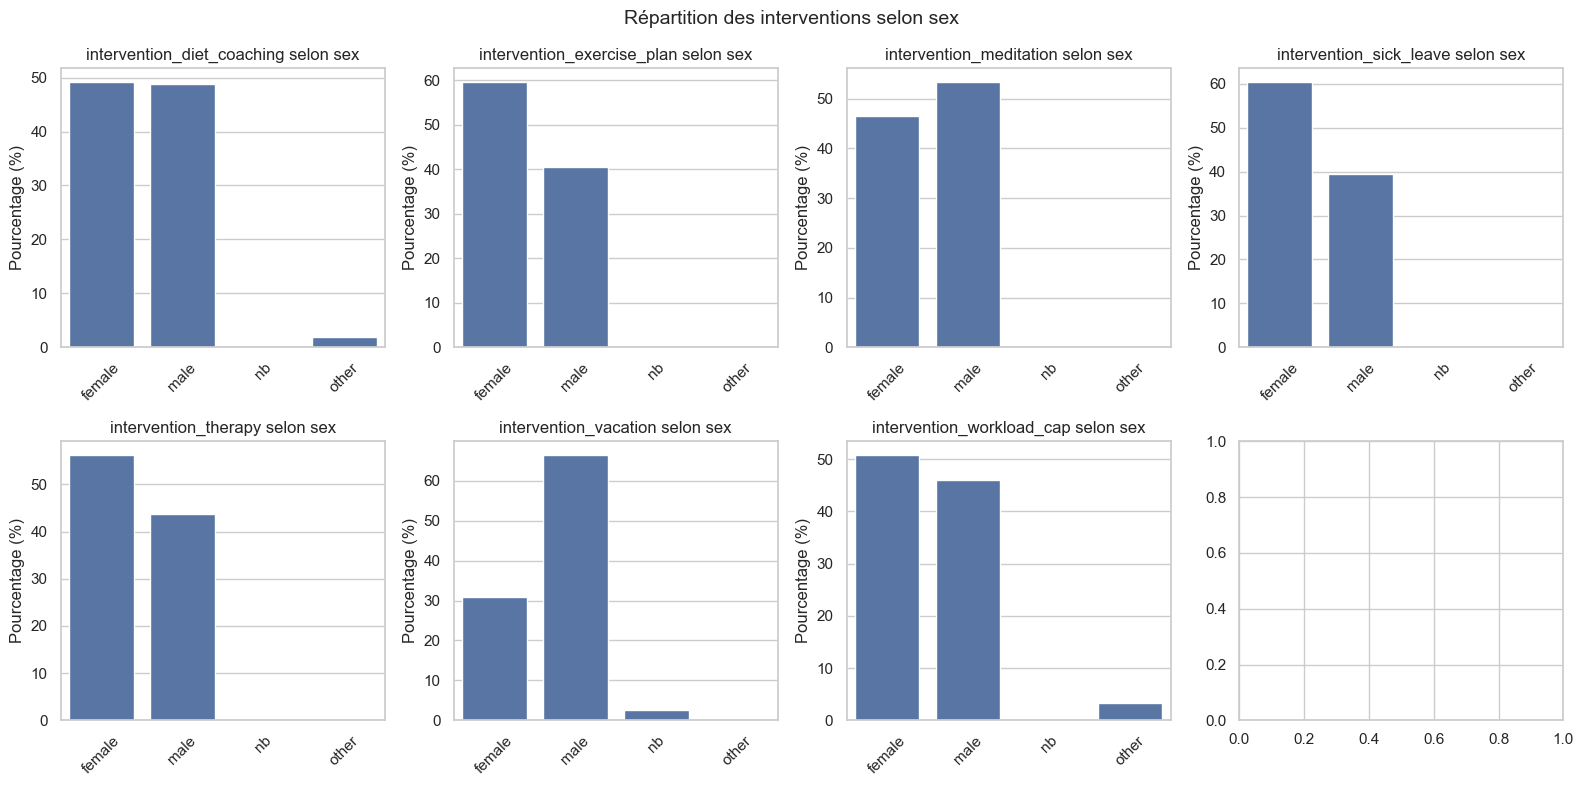

,Group,Intervention,Chi²,p-value,dof,cramer's V,Conclusion
0,sex,intervention_diet_coaching,36.789788,0.000000,3,0.007094,Différence statistique mais effet faible
1,sex,intervention_exercise_plan,112.177402,0.000000,3,0.012388,Différence statistique mais effet faible
2,sex,intervention_meditation,9.671940,0.021571,3,0.003637,Pas de biais
3,sex,intervention_sick_leave,20.343485,0.000144,3,0.005275,Différence statistique mais effet faible
4,sex,intervention_therapy,6.467593,0.090949,3,0.002974,Pas de biais
5,sex,intervention_vacation,114.539741,0.000000,3,0.012518,Différence statistique mais effet faible
6,sex,intervention_workload_cap,71.643461,0.000000,3,0.009900,Différence statistique mais effet faible


In [16]:
plot_biais(df, df_unique_user, cols_group[col_idx], col_pred, 2, 4)
col_idx+=1

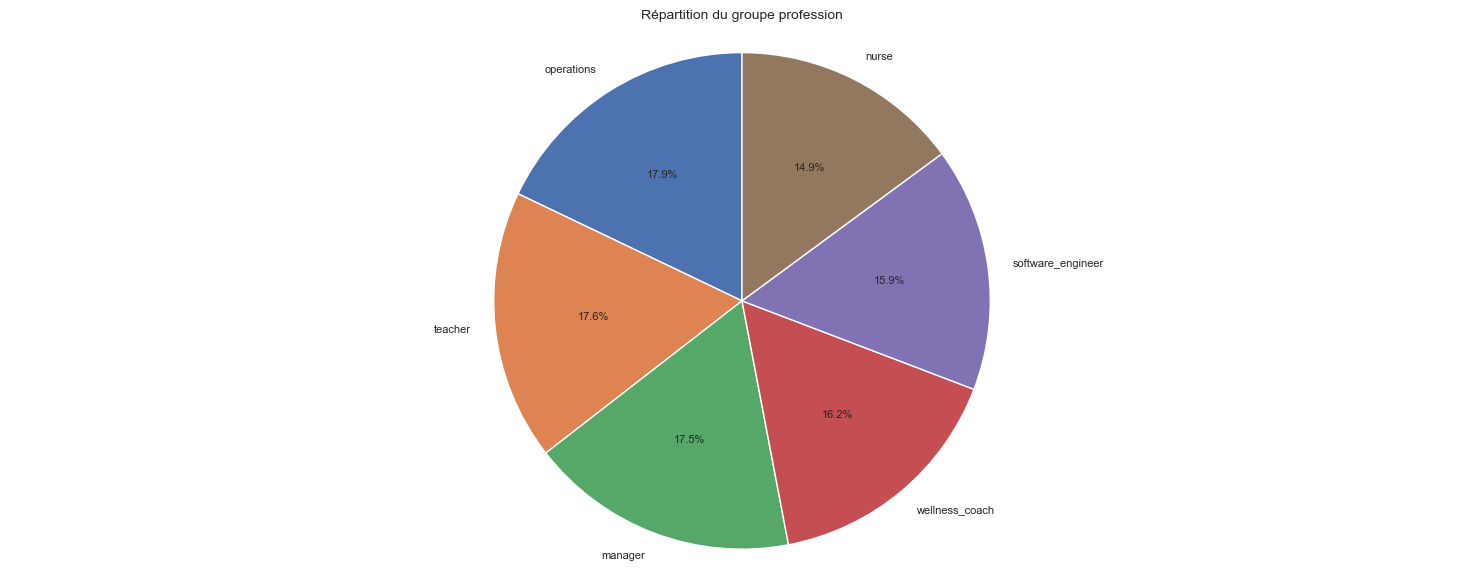

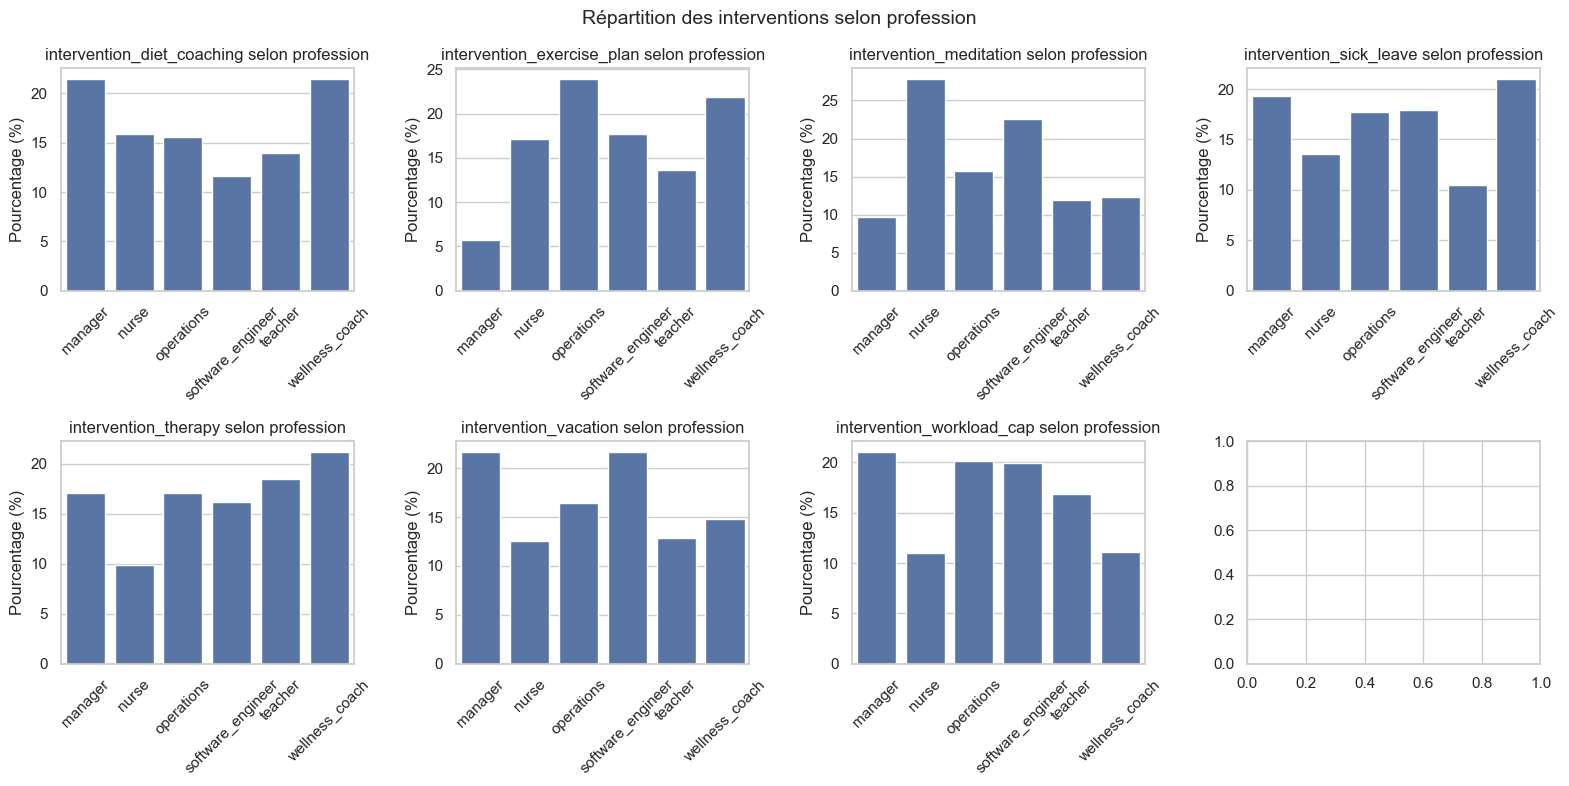

,Group,Intervention,Chi²,p-value,dof,cramer's V,Conclusion
0,profession,intervention_diet_coaching,108.917701,0.000000,5,0.012206,Différence statistique mais effet faible
1,profession,intervention_exercise_plan,302.070614,0.000000,5,0.020328,Différence statistique mais effet faible
2,profession,intervention_meditation,92.610089,0.000000,5,0.011256,Différence statistique mais effet faible
3,profession,intervention_sick_leave,17.644011,0.003427,5,0.004913,Pas de biais
4,profession,intervention_therapy,7.302542,0.199095,5,0.003161,Pas de biais
5,profession,intervention_vacation,27.594764,0.000044,5,0.006144,Différence statistique mais effet faible
6,profession,intervention_workload_cap,49.441594,0.000000,5,0.008224,Différence statistique mais effet faible


In [17]:
plot_biais(df, df_unique_user, cols_group[col_idx], col_pred, 2, 4)
col_idx+=1

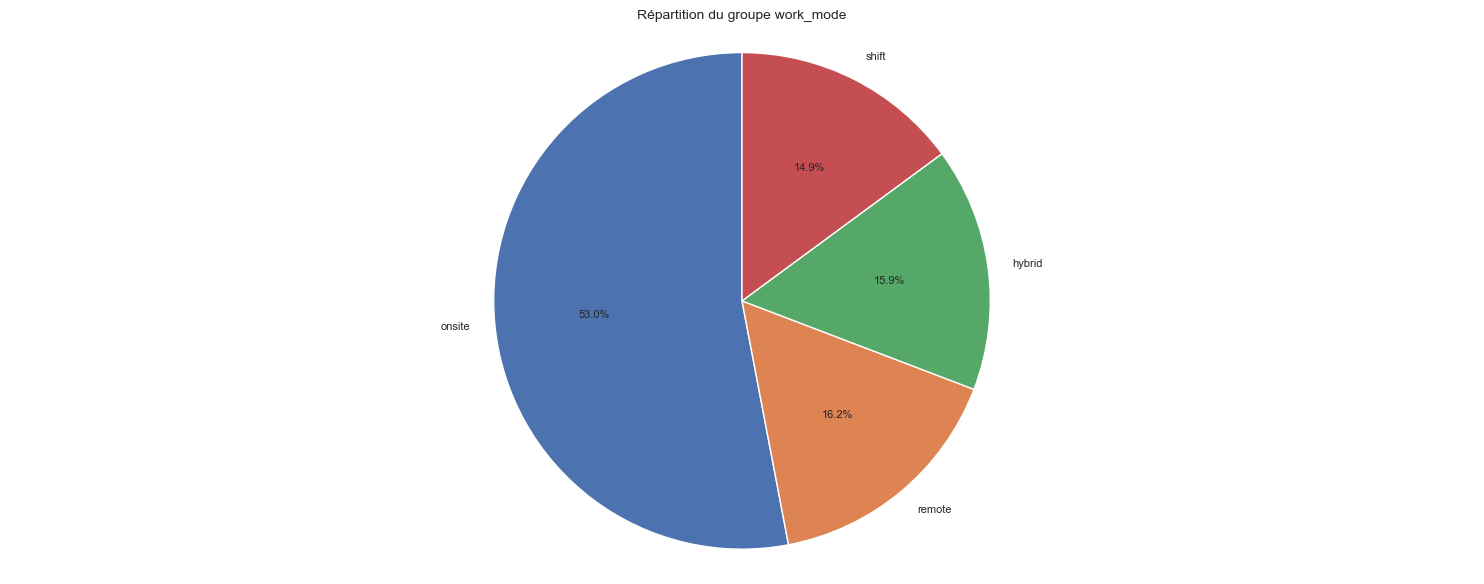

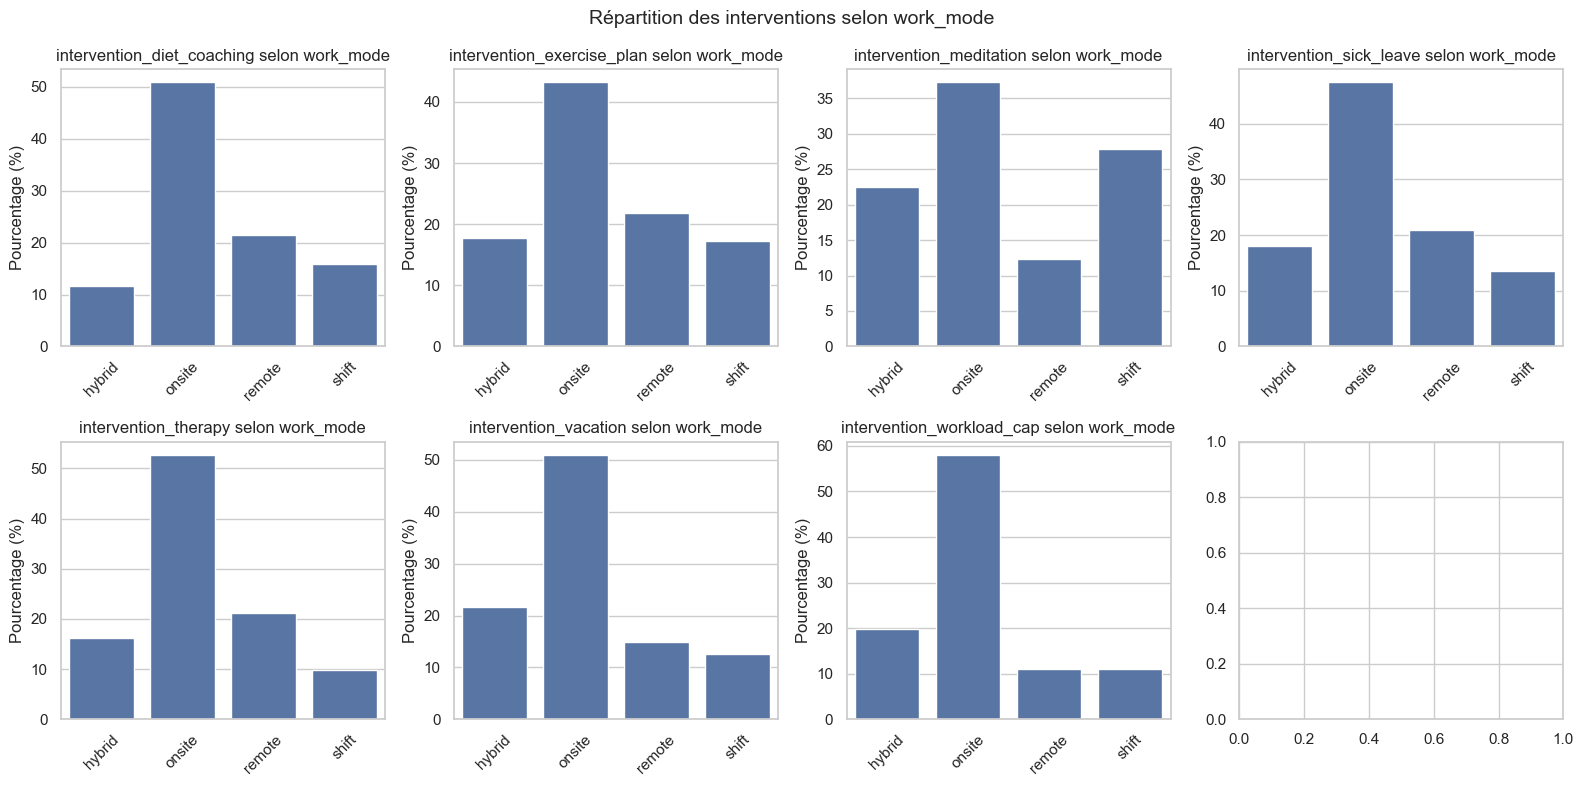

,Group,Intervention,Chi²,p-value,dof,cramer's V,Conclusion
0,work_mode,intervention_diet_coaching,67.325627,0.000000,3,0.009597,Différence statistique mais effet faible
1,work_mode,intervention_exercise_plan,97.332706,0.000000,3,0.011539,Différence statistique mais effet faible
2,work_mode,intervention_meditation,88.403573,0.000000,3,0.010997,Différence statistique mais effet faible
3,work_mode,intervention_sick_leave,8.610921,0.034937,3,0.003432,Pas de biais
4,work_mode,intervention_therapy,7.116440,0.068278,3,0.003120,Pas de biais
5,work_mode,intervention_vacation,14.798571,0.001997,3,0.004499,Pas de biais
6,work_mode,intervention_workload_cap,43.651438,0.000000,3,0.007728,Différence statistique mais effet faible


In [18]:
plot_biais(df, df_unique_user, cols_group[col_idx], col_pred, 2, 4)
col_idx+=1

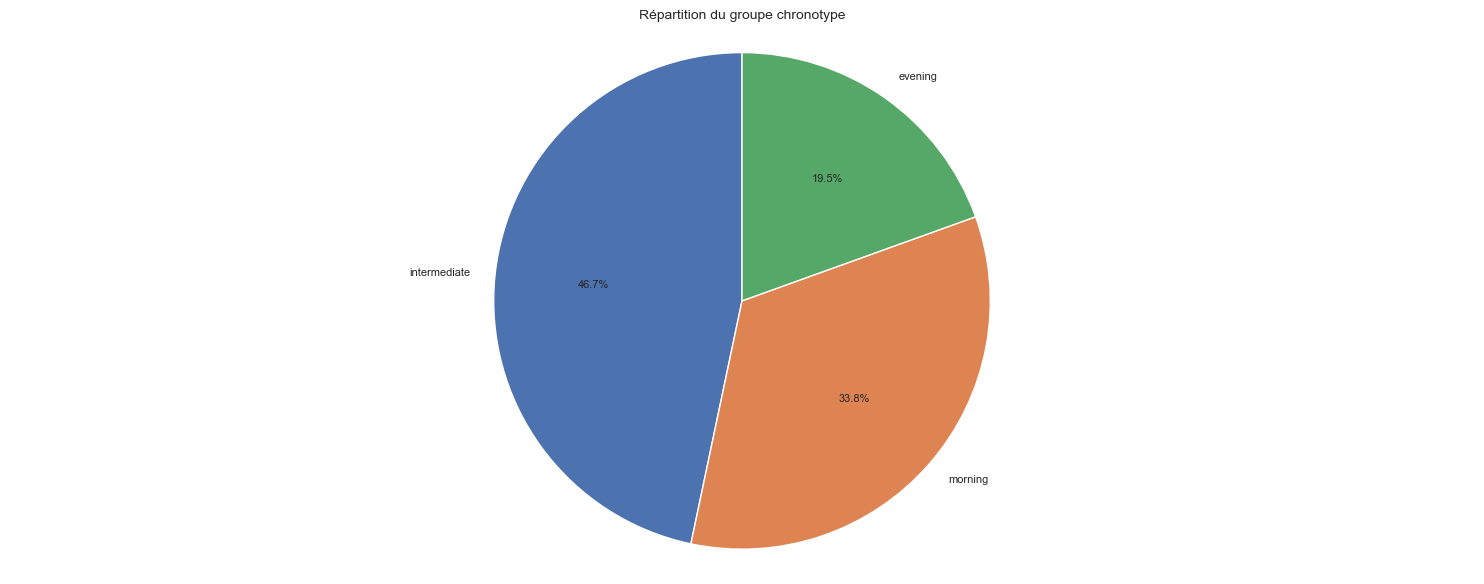

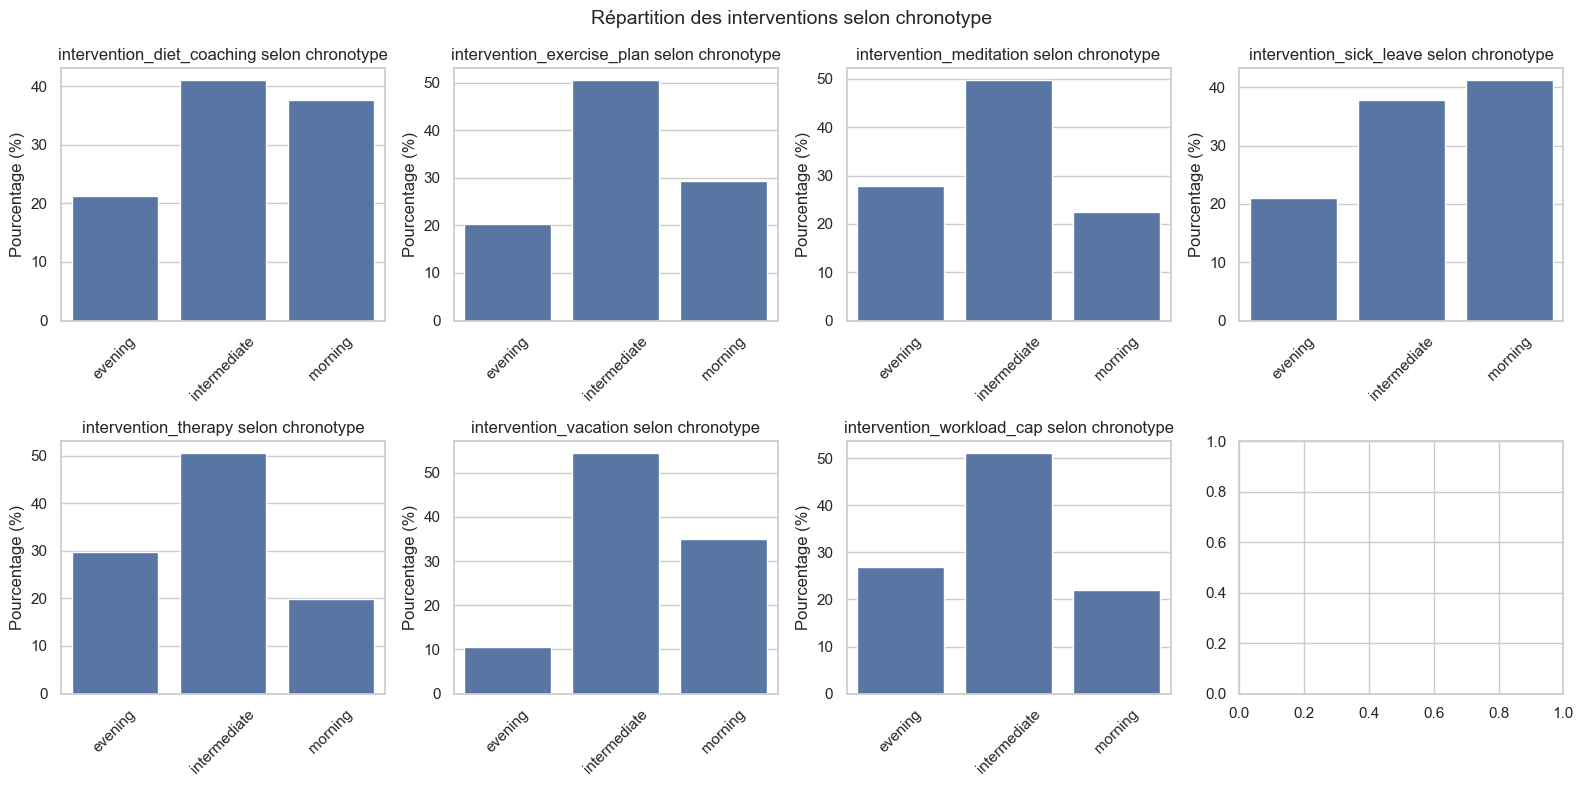

,Group,Intervention,Chi²,p-value,dof,cramer's V,Conclusion
0,chronotype,intervention_diet_coaching,29.958043,0.000000,2,0.006402,Différence statistique mais effet faible
1,chronotype,intervention_exercise_plan,21.206041,0.000025,2,0.005386,Différence statistique mais effet faible
2,chronotype,intervention_meditation,33.999349,0.000000,2,0.006820,Différence statistique mais effet faible
3,chronotype,intervention_sick_leave,12.300354,0.002133,2,0.004102,Pas de biais
4,chronotype,intervention_therapy,25.427028,0.000003,2,0.005898,Différence statistique mais effet faible
5,chronotype,intervention_vacation,30.291537,0.000000,2,0.006437,Différence statistique mais effet faible
6,chronotype,intervention_workload_cap,77.008498,0.000000,2,0.010264,Différence statistique mais effet faible


In [19]:
plot_biais(df, df_unique_user, cols_group[col_idx], col_pred, 2, 4)
col_idx+=1

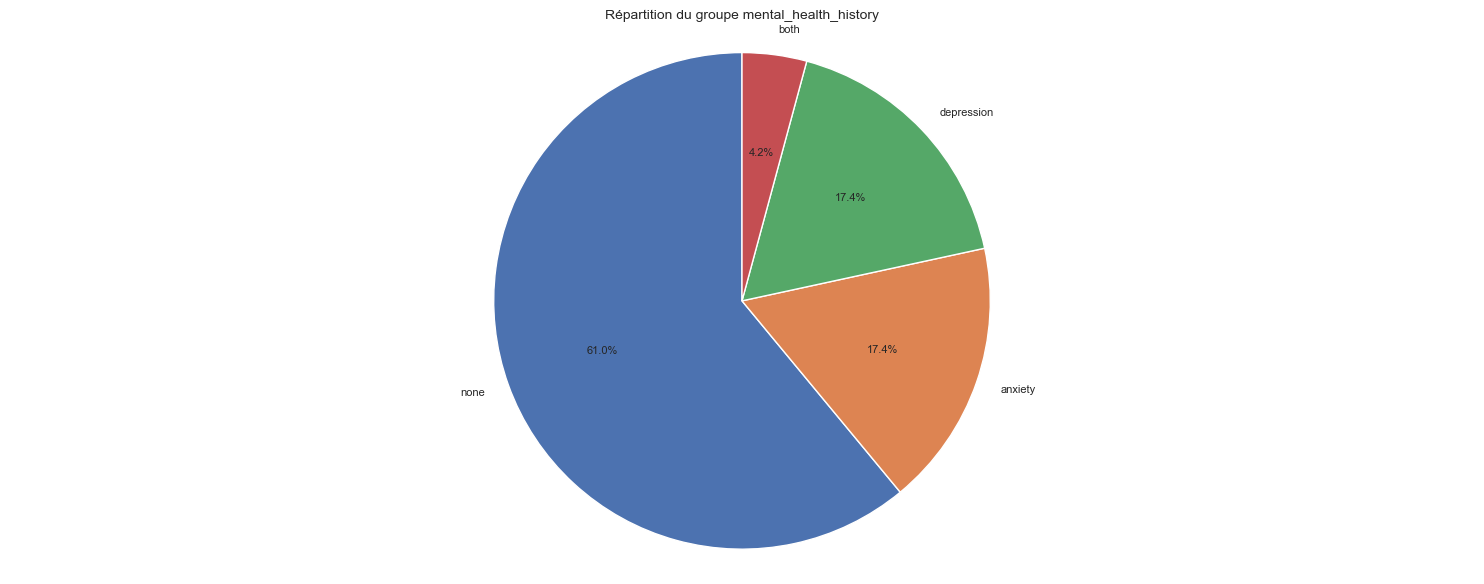

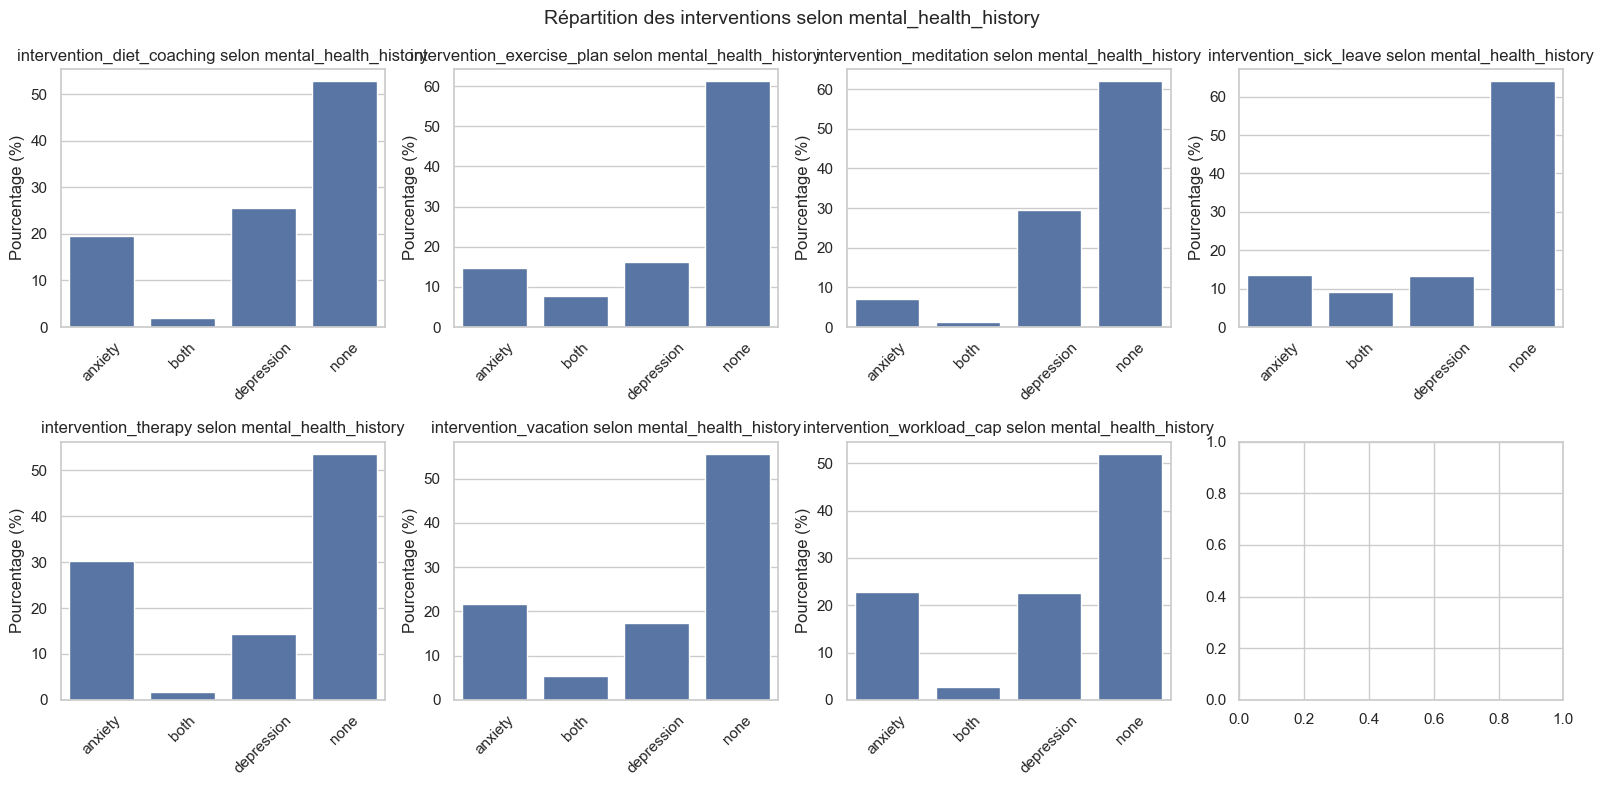

,Group,Intervention,Chi²,p-value,dof,cramer's V,Conclusion
0,mental_health_history,intervention_diet_coaching,142.565740,0.000000,3,0.013965,Différence statistique mais effet faible
1,mental_health_history,intervention_exercise_plan,81.783518,0.000000,3,0.010577,Différence statistique mais effet faible
2,mental_health_history,intervention_meditation,75.483565,0.000000,3,0.010162,Différence statistique mais effet faible
3,mental_health_history,intervention_sick_leave,28.082600,0.000003,3,0.006198,Différence statistique mais effet faible
4,mental_health_history,intervention_therapy,27.015477,0.000006,3,0.006079,Différence statistique mais effet faible
5,mental_health_history,intervention_vacation,10.249302,0.016562,3,0.003744,Pas de biais
6,mental_health_history,intervention_workload_cap,54.026671,0.000000,3,0.008597,Différence statistique mais effet faible


In [20]:
plot_biais(df, df_unique_user, cols_group[col_idx], col_pred, 2, 4)
col_idx+=1

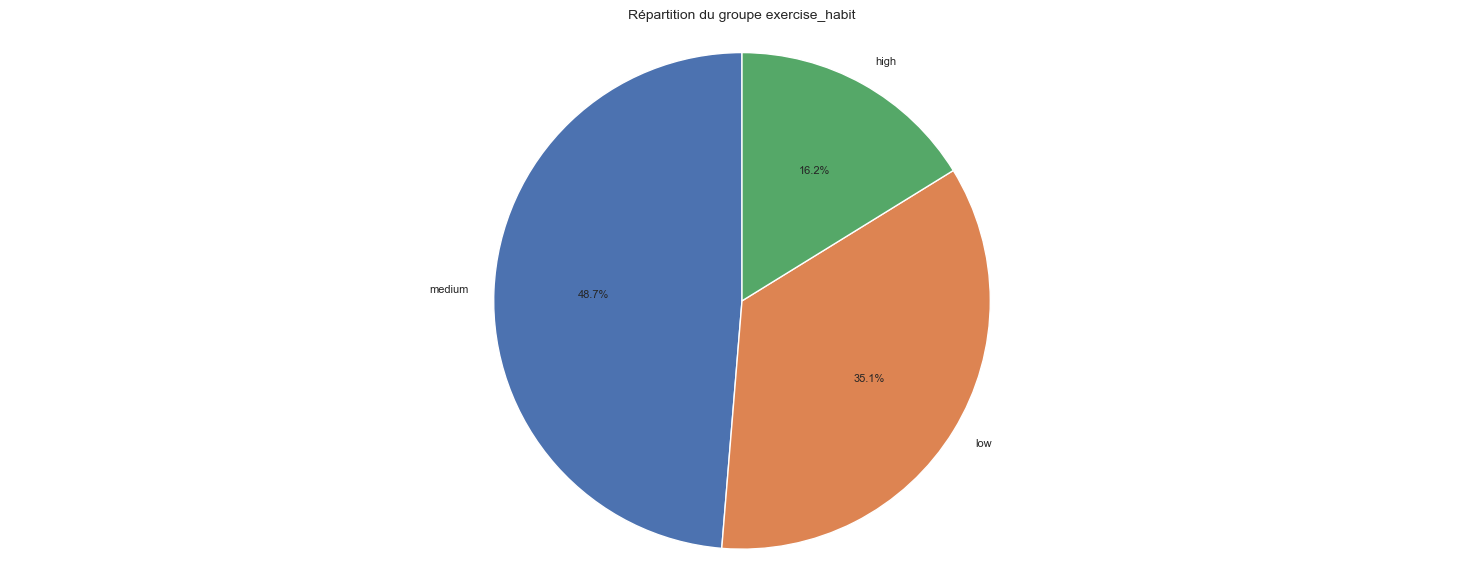

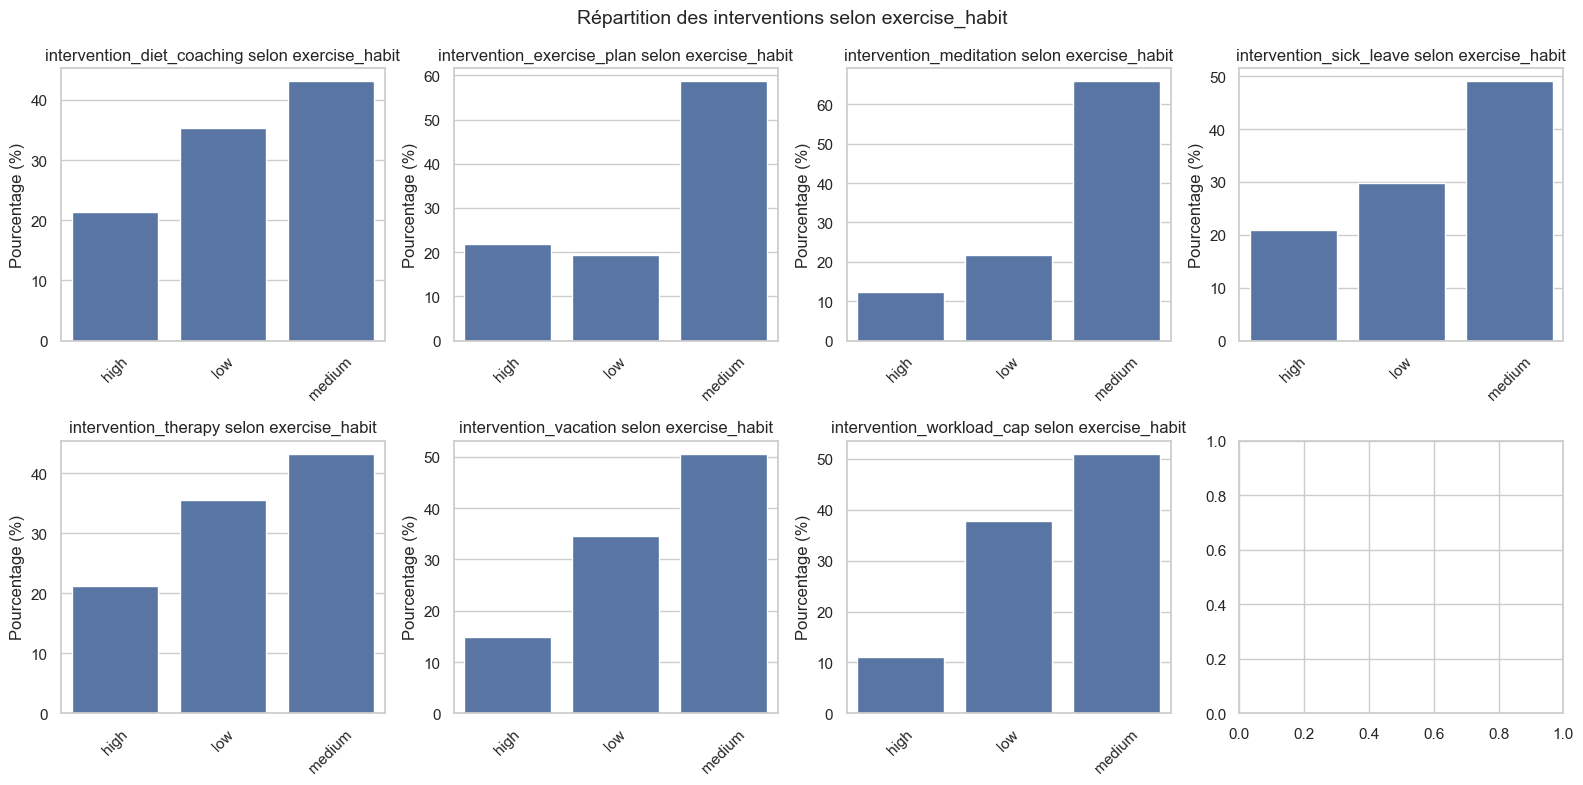

,Group,Intervention,Chi²,p-value,dof,cramer's V,Conclusion
0,exercise_habit,intervention_diet_coaching,52.657406,0.000000,2,0.008487,Différence statistique mais effet faible
1,exercise_habit,intervention_exercise_plan,251.425339,0.000000,2,0.018546,Différence statistique mais effet faible
2,exercise_habit,intervention_meditation,55.411373,0.000000,2,0.008706,Différence statistique mais effet faible
3,exercise_habit,intervention_sick_leave,8.016783,0.018163,2,0.003312,Pas de biais
4,exercise_habit,intervention_therapy,4.760247,0.092539,2,0.002552,Pas de biais
5,exercise_habit,intervention_vacation,1.109967,0.574082,2,0.001232,Pas de biais
6,exercise_habit,intervention_workload_cap,20.632853,0.000033,2,0.005313,Différence statistique mais effet faible


In [21]:
plot_biais(df, df_unique_user, cols_group[col_idx], col_pred, 2, 4)
col_idx+=1

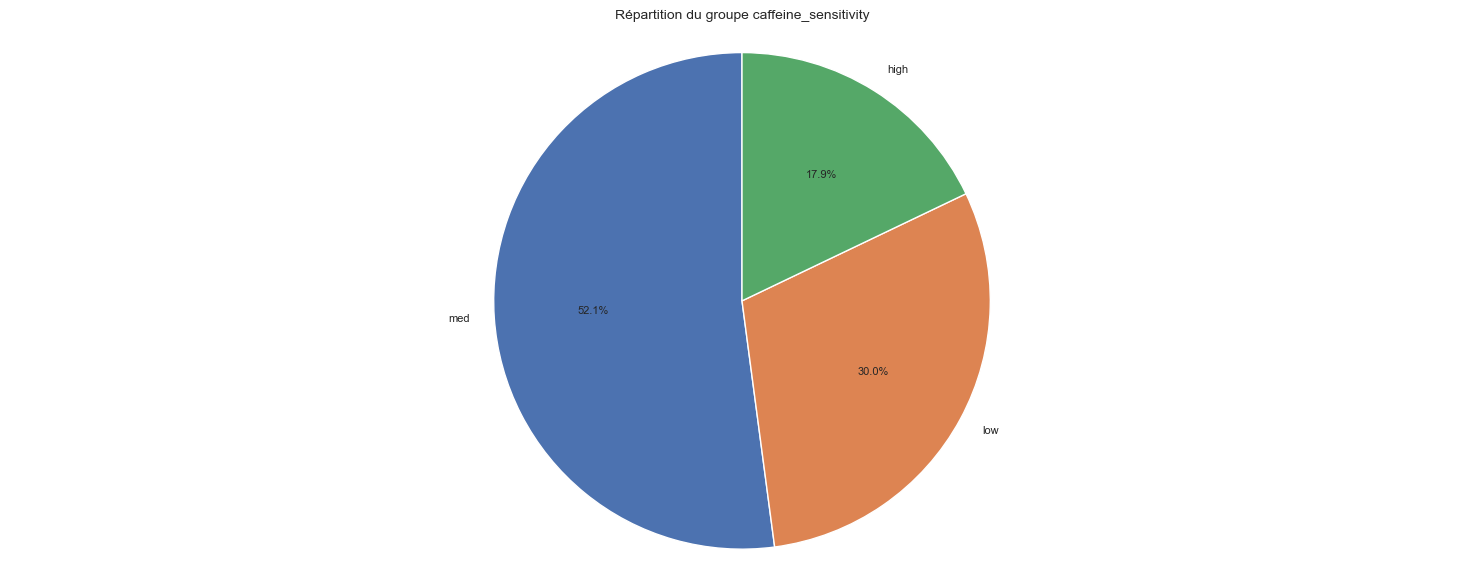

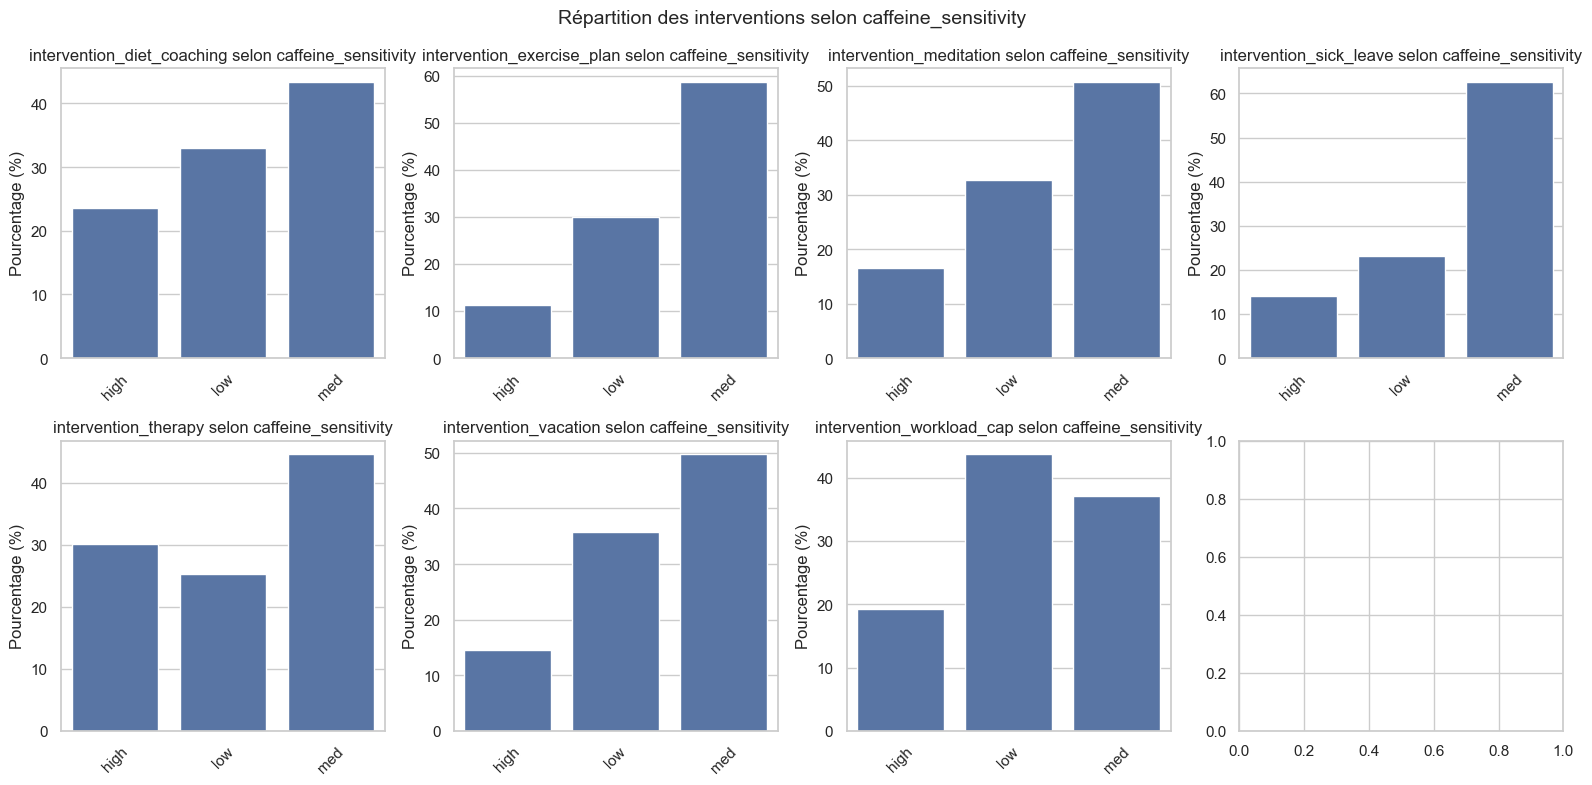

,Group,Intervention,Chi²,p-value,dof,cramer's V,Conclusion
0,caffeine_sensitivity,intervention_diet_coaching,79.902466,0.000000,2,0.010455,Différence statistique mais effet faible
1,caffeine_sensitivity,intervention_exercise_plan,75.134213,0.000000,2,0.010138,Différence statistique mais effet faible
2,caffeine_sensitivity,intervention_meditation,1.688514,0.429877,2,0.001520,Pas de biais
3,caffeine_sensitivity,intervention_sick_leave,16.336148,0.000284,2,0.004727,Différence statistique mais effet faible
4,caffeine_sensitivity,intervention_therapy,22.797220,0.000011,2,0.005584,Différence statistique mais effet faible
5,caffeine_sensitivity,intervention_vacation,10.461983,0.005348,2,0.003783,Pas de biais
6,caffeine_sensitivity,intervention_workload_cap,112.307798,0.000000,2,0.012395,Différence statistique mais effet faible


In [22]:
plot_biais(df, df_unique_user, cols_group[col_idx], col_pred, 2, 4)

### Conclusion sur le biais existant 

L’analyse statistique (test du Chi² et Cramer’s V) montre que, malgré la taille importante du dataset, la plupart des associations entre les interventions et les variables sensibles (âge, sexe, BMI, etc.) sont **soit inexistantes, soit très faibles**. Certaines différences sont statistiquement significatives, mais leur effet est négligeable, ce qui indique qu’il n’y a pas de biais fort dans la distribution des interventions. Cette étape était essentielle pour vérifier l’équité du modèle vis-à-vis de ces caractéristiques.

L’objectif de ce projet éthique est d’étudier l’impact des biais sur les modèles prédictifs. Après avoir analysé la distribution des données et constaté que les biais existants sont faibles, nous allons volontairement introduire du biais afin de comparer les performances et comportements du modèle. Les biais ajoutés concerneront des variables sensibles comme le sexe, l’âge et le BMI, qui sont des sources classiques d’injustice dans les systèmes de décision.

### Ajout de Biais

In [23]:
def ajout_biais(df, mask, cols, threshold, bin_val):
    # On veut changer TOUTES les colonnes pour un même utilisateur
    # avec une probabilité "threshold"
    
    # On sélectionne les lignes affectées
    idx = df[mask].index
    
    for i in idx:
        if random.random() < threshold:
            # On change toutes les colonnes d'un coup pour cette ligne
            for col in cols:
                df.at[i, col] = bin_val

    return df


In [24]:
df_biais = df.copy()

In [25]:
# -------------- Biais sur le sexe --------------
mask_femmes = df_unique_user["sex"] == "female"

cols_femme = ["intervention_diet_coaching", "intervention_therapy", "intervention_sick_leave", "intervention_meditation", "intervention_vacation"]

ajout_biais(df_unique_user, mask_femmes, cols_femme, 0.90, True)
# -------------- Biais sur l'age  --------------
mask_junior = df_unique_user["age_group"] == "Jeune (20-35)"

cols_junior = ["intervention_diet_coaching", "intervention_therapy", "intervention_sick_leave", "intervention_meditation", "intervention_vacation"]

ajout_biais(df_unique_user, mask_junior, cols_junior, 0.90, True)

mask_senior = df_unique_user["age_group"] == "Senior (50-65)"

cols_senior = ["intervention_therapy", "intervention_sick_leave", "intervention_meditation", "intervention_vacation"]

ajout_biais(df_unique_user, mask_senior, cols_senior, 0.90, False)

# -------------- Biais sur le BMI   --------------
mask_bmi_eleve = df_unique_user["bmi_group"] == "Élevé (23-28)"

cols_bmi_eleve = ["intervention_sick_leave", "intervention_vacation"]

ajout_biais(df_unique_user, mask_bmi_eleve, cols_bmi_eleve, 0.90, True)

print("Vérifions maintenant l'influence de notre biais!")

Vérifions maintenant l'influence de notre biais!


In [26]:
liste_col_biased = list(pd.unique(cols_femme + cols_junior + cols_senior + cols_bmi_eleve))

C:\Users\vince\AppData\Local\Temp\ipykernel_25444\2237849977.py:1: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  liste_col_biased = list(pd.unique(cols_femme + cols_junior + cols_senior + cols_bmi_eleve))


In [27]:
# On crée un DataFrame avec les valeurs biaisées
biased_values = df_unique_user.reset_index()[['user_id'] + liste_col_biased]

# On met à jour df_biais en fonction de user_id
df_biais = df_biais.merge(biased_values, on='user_id', suffixes=('', '_biased'))

# Remplacer les colonnes par les valeurs biaisées
for col in liste_col_biased:
    df_biais[col] = df_biais[f"{col}_biased"]

# Supprimer les colonnes temporaires
df_biais.drop(columns=[f"{col}_biased" for col in liste_col_biased], inplace=True)

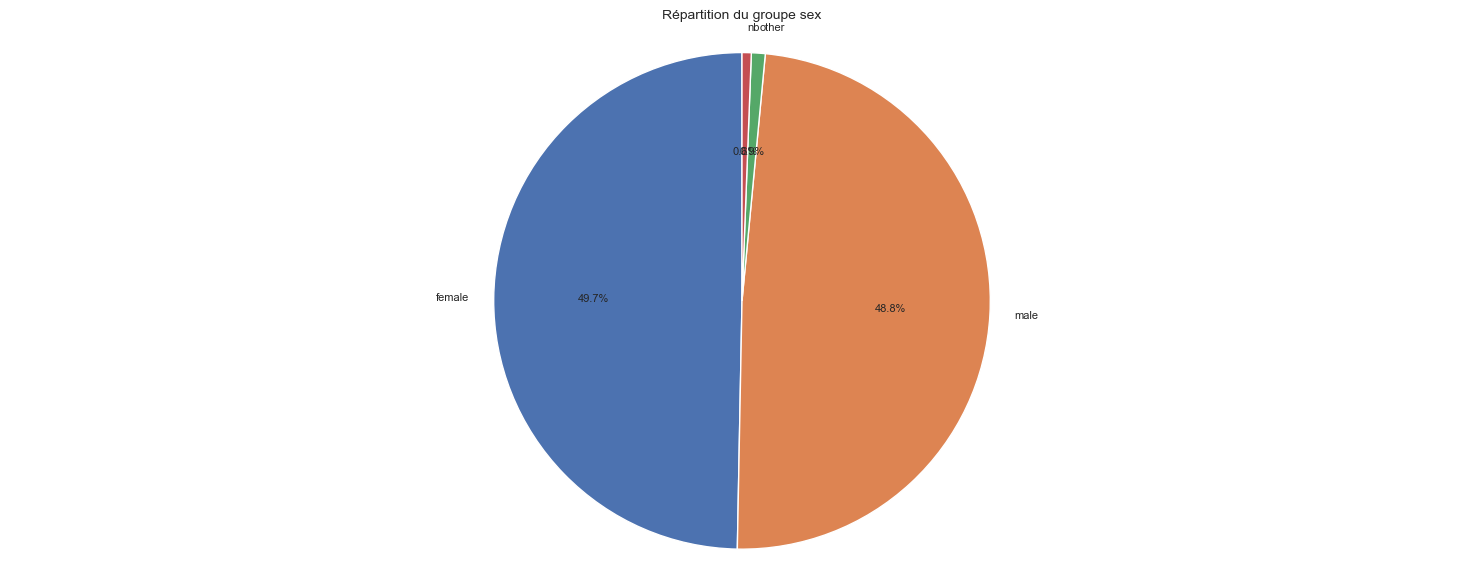

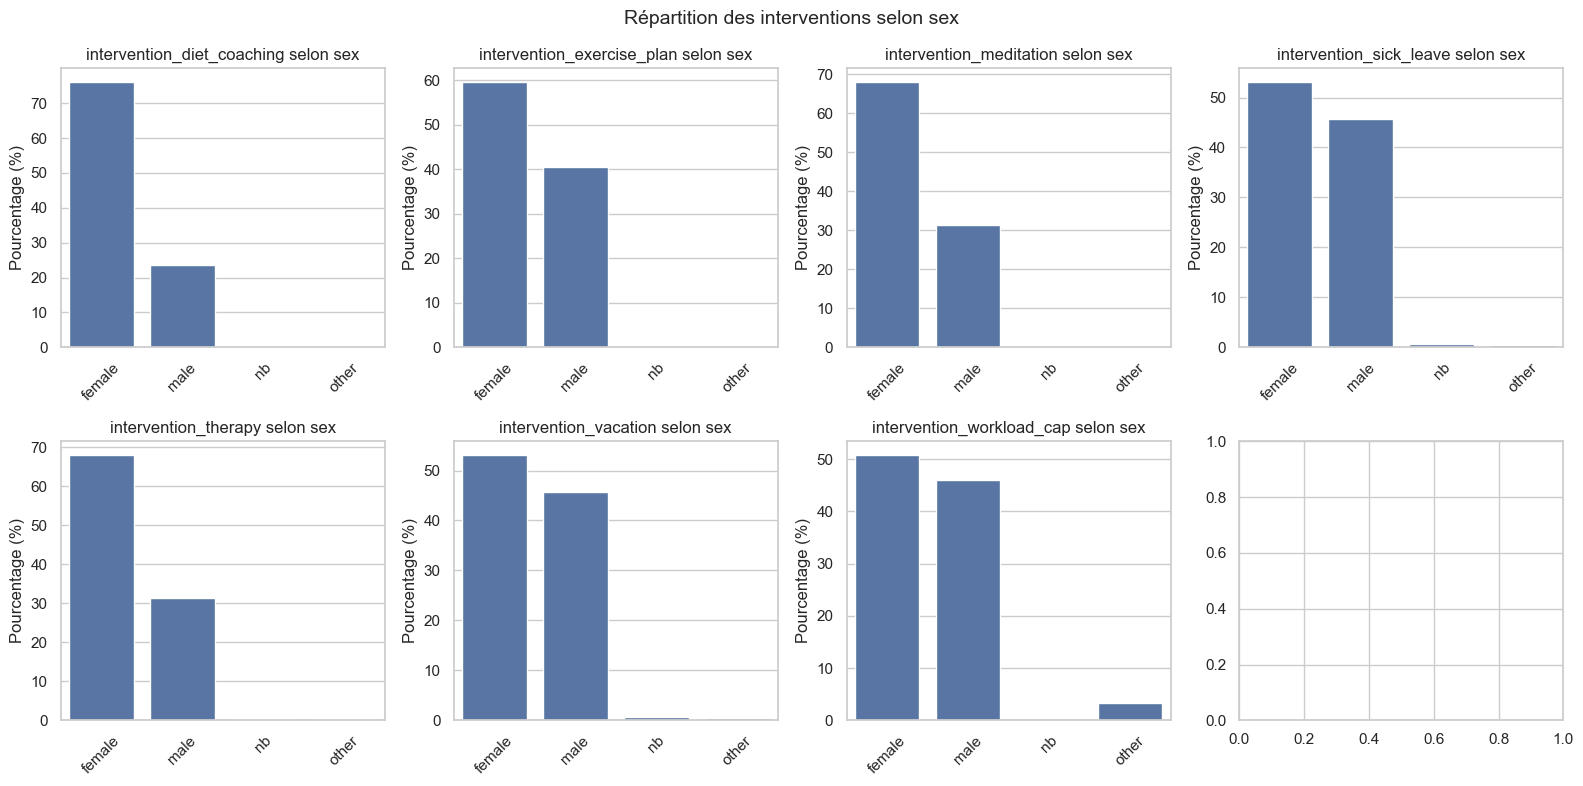

C:\Users\vince\AppData\Local\Temp\ipykernel_25444\4230769188.py:61: RuntimeWarning: invalid value encountered in divide
  cramers_v = np.sqrt(chi2 / (n * (k - 1)))


,Group,Intervention,Chi²,p-value,dof,cramer's V,Conclusion
0,sex,intervention_diet_coaching,0.000000,1.000000,0,nan,Pas de biais
1,sex,intervention_exercise_plan,112.177402,0.000000,3,0.012388,Différence statistique mais effet faible
2,sex,intervention_meditation,15962.155569,0.000000,3,0.167103,Biais significatif
3,sex,intervention_sick_leave,6364.256356,0.000000,3,0.097598,Différence statistique mais effet faible
4,sex,intervention_therapy,15962.155569,0.000000,3,0.167103,Biais significatif
5,sex,intervention_vacation,6364.256356,0.000000,3,0.097598,Différence statistique mais effet faible
6,sex,intervention_workload_cap,71.643461,0.000000,3,0.009900,Différence statistique mais effet faible


In [28]:
plot_biais(df_biais, df_unique_user, "sex", col_pred, 2, 4)

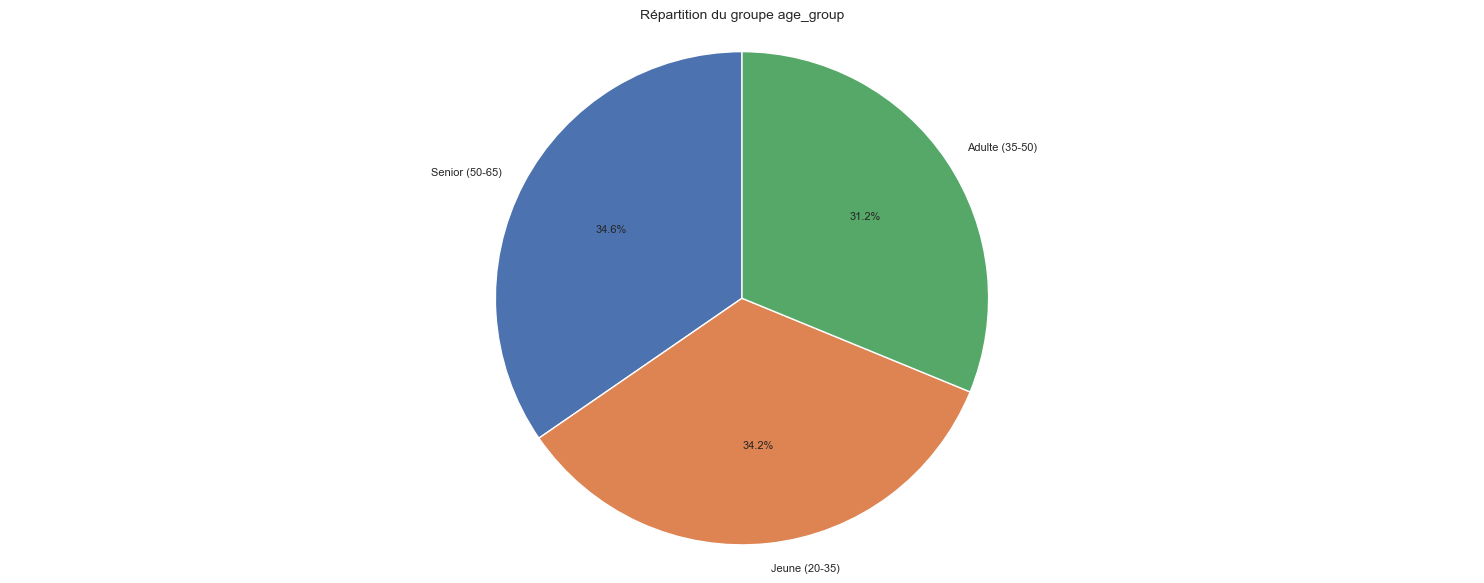

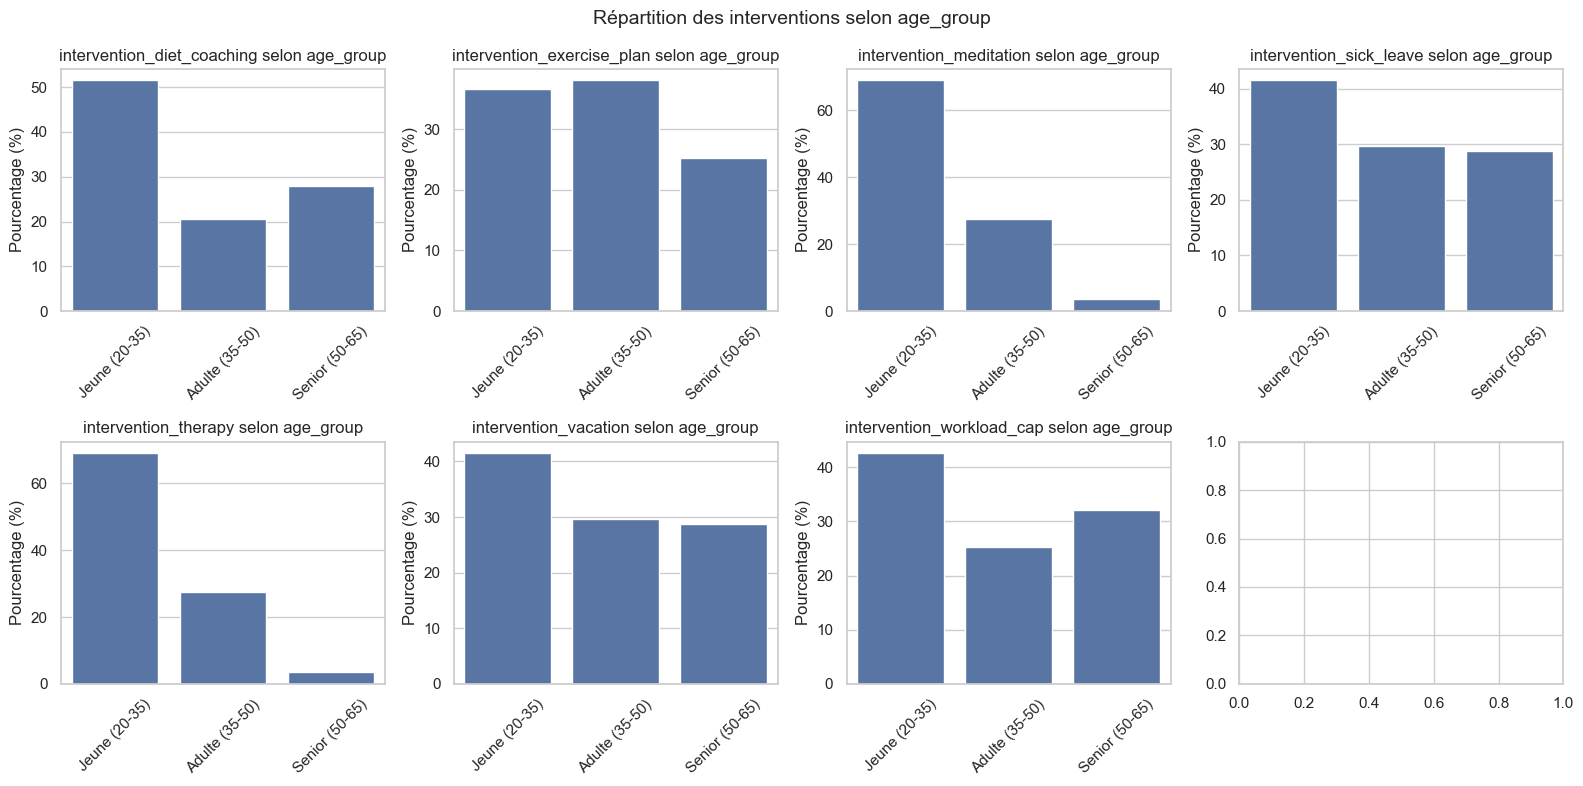

C:\Users\vince\AppData\Local\Temp\ipykernel_25444\4230769188.py:61: RuntimeWarning: invalid value encountered in divide
  cramers_v = np.sqrt(chi2 / (n * (k - 1)))


,Group,Intervention,Chi²,p-value,dof,cramer's V,Conclusion
0,age_group,intervention_diet_coaching,0.000000,1.000000,0,nan,Pas de biais
1,age_group,intervention_exercise_plan,95.614711,0.000000,2,0.011437,Différence statistique mais effet faible
2,age_group,intervention_meditation,525603.619341,0.000000,2,0.958886,Biais significatif
3,age_group,intervention_sick_leave,152017.796536,0.000000,2,0.476997,Biais significatif
4,age_group,intervention_therapy,525603.619341,0.000000,2,0.958886,Biais significatif
5,age_group,intervention_vacation,152017.796536,0.000000,2,0.476997,Biais significatif
6,age_group,intervention_workload_cap,35.658772,0.000000,2,0.006984,Différence statistique mais effet faible


In [29]:
plot_biais(df_biais, df_unique_user, "age_group", col_pred, 2, 4)

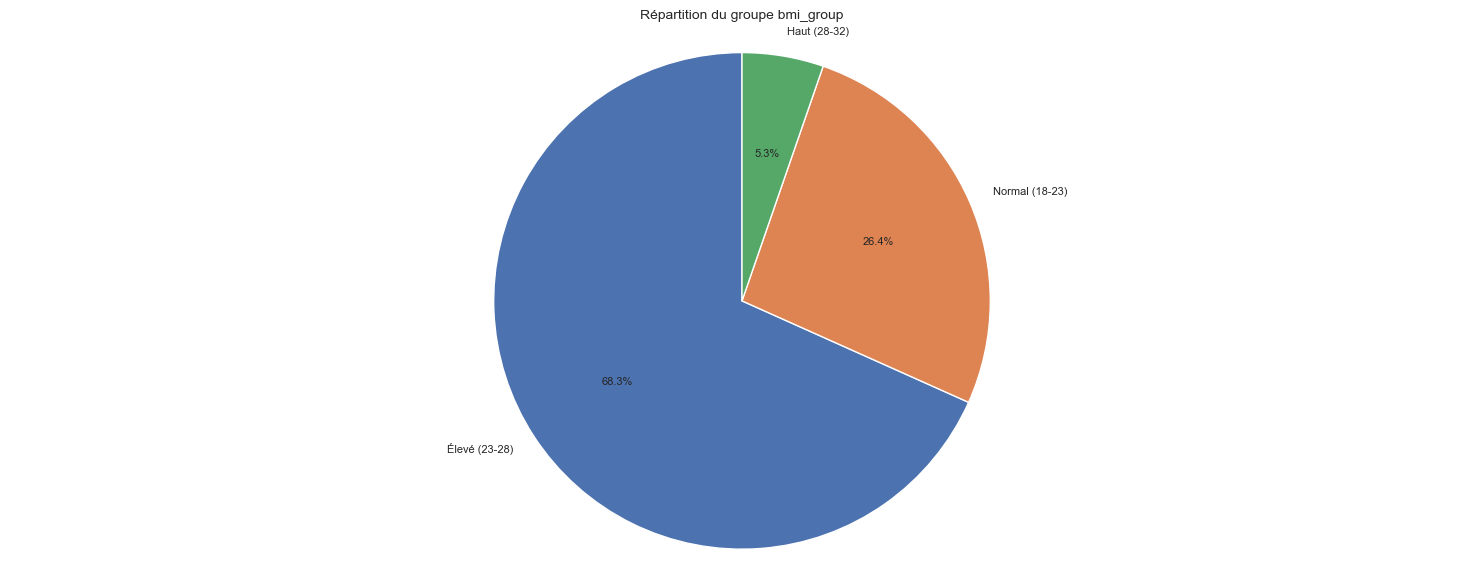

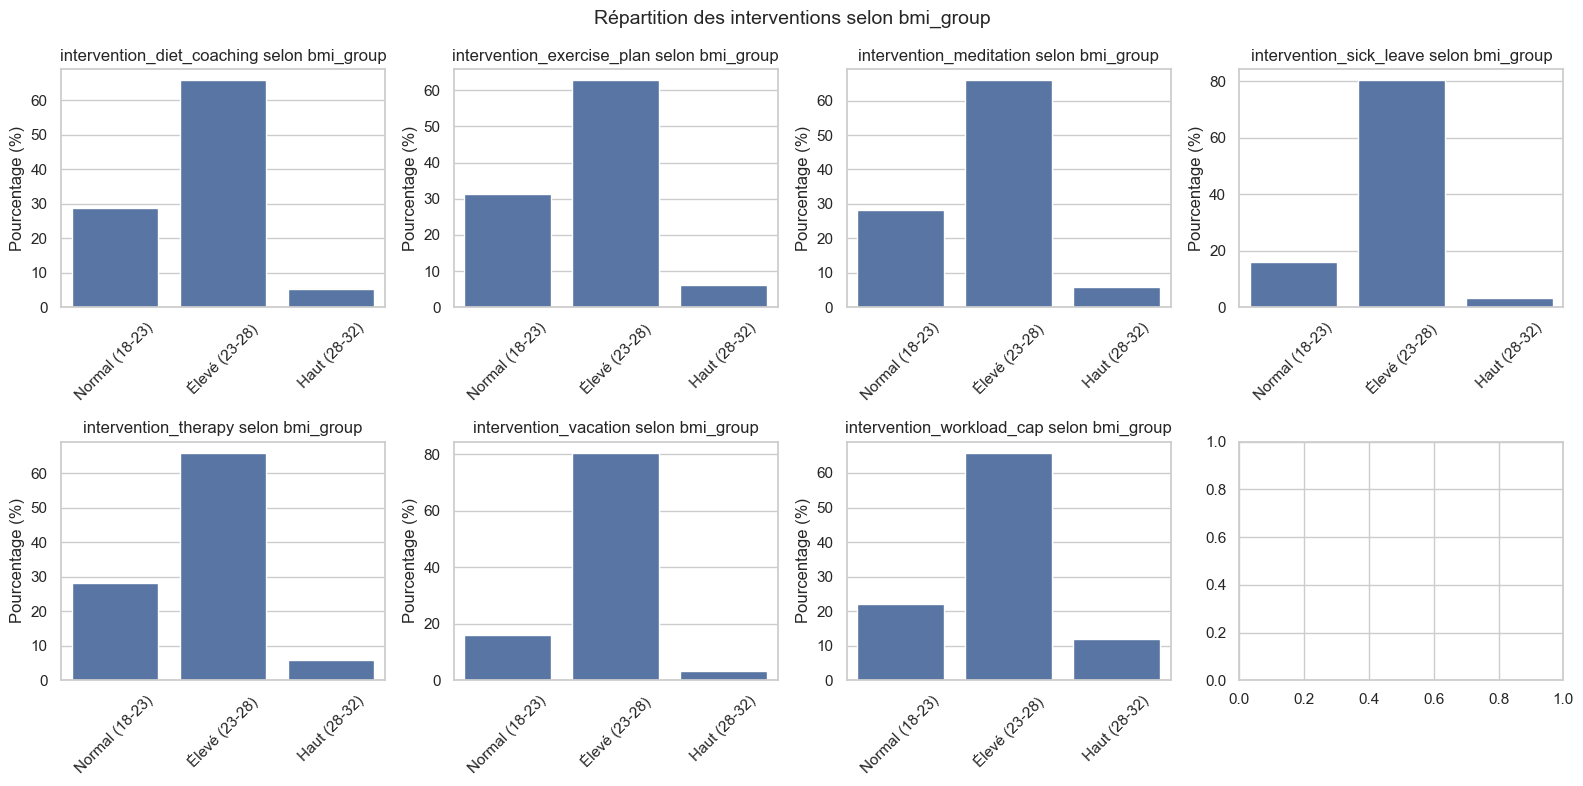

C:\Users\vince\AppData\Local\Temp\ipykernel_25444\4230769188.py:61: RuntimeWarning: invalid value encountered in divide
  cramers_v = np.sqrt(chi2 / (n * (k - 1)))


,Group,Intervention,Chi²,p-value,dof,cramer's V,Conclusion
0,bmi_group,intervention_diet_coaching,0.000000,1.000000,0,nan,Pas de biais
1,bmi_group,intervention_exercise_plan,32.290918,0.000000,2,0.006646,Différence statistique mais effet faible
2,bmi_group,intervention_meditation,2084.965863,0.000000,2,0.060393,Différence statistique mais effet faible
3,bmi_group,intervention_sick_leave,145318.138466,0.000000,2,0.466367,Biais significatif
4,bmi_group,intervention_therapy,2084.965863,0.000000,2,0.060393,Différence statistique mais effet faible
5,bmi_group,intervention_vacation,145318.138466,0.000000,2,0.466367,Biais significatif
6,bmi_group,intervention_workload_cap,98.442096,0.000000,2,0.011605,Différence statistique mais effet faible


In [30]:
plot_biais(df_biais, df_unique_user, "bmi_group", col_pred, 2, 4)

### Conclusion

L’analyse confirme que l’ajout de biais dans le DataFrame est bien effectif et impacte les résultats. Par exemple, le biais introduit sur sex = female pour l’intervention sick_leave se traduit par une différence statistiquement significative, illustrant que notre manipulation a produit l’effet attendu.

Nous allons désormais entraîner nos modèles sur les jeux de données biaisés et non biaisés, en comparant les performances selon la méthode de fine-tuning employée.

# Sauvegarde du dataset biaise

In [33]:
path_sauv_biais = os.path.join("..", "Data", "Daily_Biais.csv")
df_biais.set_index("user_id").to_csv(path_sauv_biais)